In [93]:
# TODO
# scale all variables
# number of outliers

In [1]:
# load data and libraries
library(openxlsx)
library(lme4)
library(ggplot2)
#source('modeling_functions.r')
################source('modeling_functions.COPY.7_13_16.r')
library(caret)
#install.packages('DAAG',repo='http://cran.stat.ucla.edu/')
#library(boot)

### multiplot
library(gridExtra)
library(grid)
library(lattice)
library(RegressionModelPipeline)
library(gridExtra)

Warning message:
: package ‘lme4’ was built under R version 3.2.3Loading required package: Matrix
Warning message:
: package ‘ggplot2’ was built under R version 3.2.4Warning message:
: package ‘caret’ was built under R version 3.2.4Loading required package: lattice


In [2]:
# load matrixes

# load Final assesment with CSBS
Final_Assessment_First_CSBS = read.xlsx('data/FinalAssessment_FirstCSBS_6.14.16.xlsx',sheet=1)
colnames(Final_Assessment_First_CSBS)[colnames(Final_Assessment_First_CSBS)=='subjectId'] = 'subjectid'
# Normalize CSBS by age and cut into performance groups
Final_Assessment_First_CSBS$CSBS_Total_1_perMo = Final_Assessment_First_CSBS$CSBS_Total_1/Final_Assessment_First_CSBS$CSBS_ageMo_1
Final_Assessment_First_CSBS$CSBS_Total_1_perMo_factor = cut(Final_Assessment_First_CSBS$CSBS_Total_1_perMo,breaks=c(0,1.5,2.5,5))
#Final_Assessment_First_CSBS$CSBS_Total_1_perMo_factor = cut(Final_Assessment_First_CSBS$CSBS_Total_1_perMo,breaks=c(-1,1,2,3,5))
Feed = read.xlsx('data/Infant_feeding_7.18.16.xlsx',sheet=1)
#Feed = read.xlsx('Infant_feeding_6.14.16.xlsx',sheet=1)
colnames(Feed) = gsub('-','\\.',colnames(Feed))
Feed$AgeMo_Infant_feeding = Feed$AgeMo
dim(Feed)
table(Feed$dxCode)
#Feed$dxCode = as.factor(Feed$dxCode,levels=c('TD','ASD'))
colnames(Feed)[colnames(Feed)=='subjectId'] = 'subjectid'
# Load Vegitable/Fruit data with color classification
FrVg_color = read.xlsx('data/Vegetables_and_Fruits_Combined_Dataset_ColorScheme2_05282016xlsb.xlsx',sheet = 1)
dim(FrVg_color)
FrVg_color[FrVg_color==''|FrVg_color=='-']=NA
FrVg_color$dxCode = as.factor(FrVg_color$dxCode)
# Load Vegitable/Fruit data with nutrient classification
FrVg_nutri = read.xlsx('data/Vegetables_and_Fruits_Combined_Dataset_NutrientsProfile_05282016.xlsx',sheet = 1)
dim(FrVg_nutri)
FrVg_nutri[FrVg_nutri==''|FrVg_nutri=='-']=NA
FrVg_nutri$dxCode = as.factor(FrVg_nutri$dxCode)

# 
table(Feed$recentDx)

[1] 479  61


ASD  TD 
293 186 

[1] 479  90

[1] 479  85


Autism Spectrum Diso             Autistic          NormControl 
                  79                  180                   72 
             PDD-NOS               PDDNOS         Type 1 Error 
                  12                   22                   18 
          Type1Error              typical              Typical 
                  70                    1                   25 

## Methods: 
### Data Included

Infant feeding questionares were analyzed to search for feeding patterns associated with Autism. Feeding quesitonares were availiable for 479 of subjects, 293 Autistic (ASD) and 186 Typically Developing (TD) at final diagnosis (Age>29 months). The feeding survey was completed by a parent or gaurdian (before/after/during) their child's assessment. Child age, birth order, parent were all recorded in the survey for control. The infant feeding survey contains a range of feeding habbit (choking, spitting, trantrums, crying), feeding content (vegitables, fish, meat, fruit), gastric disruption (reflux, bloating, diarea) and several other variables including food consumed that day. A complete list of question on the feeding survey can be found [...]. The feeding survey is intended to gather broad information on nutritional, behavioral and gastro intestial status of the child being assessed. [instructions given to the parent of guardian: time frame of answers,...]


The last question on the feeding survey, reguarding food consumed that day, was expanded to examine the importance of nutritional diversity. We examined both specific nutrient such as folate as well as the heuristic color categorization of fruits and vegitables consumed. Specific nutrient were selected [...]. The color categorization from [...] was implimented to determine the degree of nutritritional diversity acheived by each subject on the day of examination.


Final Scores from the Communication and Symbolic Behavior Screen (CSBS) given between 12 and 24 months was also included in analysis. The CSBS is an indication of developmental delay risk. It was used to control for prior risk of developmental delay at 12-24 months of age.

#### Age groups: Intake, Intermediated, Final Diagnosis
Subjects were split into three clinically relevant age groupings: Intake (10-24 months), Intermediate (24-36 months) and Final Diagnosis (36-100 months). This segregations allows us to account for biases arrising due to the different stages of maturity as well as parental bias in response to diagnostic involvement.

In [3]:
# combine data
FrVg_color = merge(FrVg_color[,unique(colnames(FrVg_color))],Final_Assessment_First_CSBS,all = TRUE)
FrVg_nutri = merge(FrVg_nutri[,unique(colnames(FrVg_nutri))],Final_Assessment_First_CSBS,all = TRUE)
Final_Assessment_First_CSBS = merge(Final_Assessment_First_CSBS,FrVg_color[,c('subjectid','dxCode')] ,all = TRUE )
Feed = merge(Feed,Final_Assessment_First_CSBS,all.x = TRUE)

In [4]:
g = ggplot(data=Feed,aes(x=AgeMo_Infant_feeding,fill=dxCode)) + geom_density(alpha=.8)
#g2 = ggplot(data=Feed,aes(x=AgeMo_Infant_feeding,fill=dxCode)) + geom_density(alpha=.8)
#

In [5]:
# age groups
#tmp$age_group = cut(tmp$AgeMo_Infant_feeding,breaks = c(10,15,20,25,30))
#tmp$age_group = cut(tmp$AgeMo_Infant_feeding,breaks = c(10,15,20,25,30,40,50,100))
#tmp$age_group = cut(tmp$AgeMo_Infant_feeding,breaks = c(10,24,36,48,100))
#Feed$age_group = cut(Feed$AgeMo_Infant_feeding,breaks = c(10,20,40,100))
Feed$age_group = cut(Feed$AgeMo_Infant_feeding,breaks = c(10,24,36,100)) # Intake, intermediate, final dx
    
thresh1 = 24; thresh2 = 36
age_group_names = c('Intake','Intermediate','Final Diagnosis')
Feed$age_group_named = factor(ifelse(Feed$age_group==levels(Feed$age_group)[1],age_group_names[1],
                                    ifelse(Feed$age_group==levels(Feed$age_group)[2],age_group_names[2],
                                        ifelse(Feed$age_group==levels(Feed$age_group)[3],age_group_names[3],NA) ) ) )


table(Feed$dxCode,Feed$age_group) 

     
      (10,24] (24,36] (36,100]
  ASD     114     106       72
  TD      145      13       27

#### Discussion point: label imbalance
There is a notable label imbalance with respect to time. This may be mitigated by using local averaging techniques such as splines over all datapoints. Statistical assessments should be restricted within ranges where the label imbalance may be adequetely controlled. For this study, we have seperate the data into younger (less than 24 months), medium (24-36 months) and older (36-48

### Excluded Variables
Feeding survey questions were checked for problematic attributes. Feeding survey variables with low variance (a ratio of first/second most abundant value greater than 20 for categorical values) or if the number of missing values exceeded 10%. Removed survey questions include: NGF feeding, Reflux related questions, breast feeding start and end, and feed count. [edit variable names]

### Excluded Data
One TD was excluded for having extremely high GIC. Subject C5D9N was not a representative individual. It is extremely unusual to have a uGIC at 40 months; this individually (has/likely-has) a chronic GI disturbance.

In [6]:
# Variable quality control
overfitters = c('Q12.EatsSoftOnly','Q22.Vomits','Q24.Chewing') #,'Q25.NGFeed','Q34.Reflux','Q34a.RflxDiag','Q34b.RflxDocVisits')
vars = colnames(Feed)[grepl('Q',colnames(Feed))]
bad_vars = colnames(Feed[,vars])[ unique( c( nearZeroVar(Feed[!is.na(Feed$dxCode),vars]) , which(apply(Feed[!is.na(Feed$dxCode),vars],2,function(x) sum(is.na(x)))>50) ))]
bad_vars = unique(c(bad_vars,overfitters)) # Q12 is bad bc low variance, min==median
#print(bad_vars)
bad_subj = c('C5D9N')
#tmp = nearZeroVar(Feed[!is.na(Feed$dxCode),vars],saveMetrics = TRUE)
#tmp
summary(Feed[!is.na(Feed$dxCode),bad_vars])
#apply(Feed[!is.na(Feed$dxCode),bad_vars],2,function(x) var(na.omit(x)))

   Q25.NGFeed      Q34.Reflux    Q34a.RflxDiag      Q34b.RflxDocVisits
 Min.   :1.000   Min.   :1.000   Length:479         Min.   : 0.000    
 1st Qu.:1.000   1st Qu.:1.000   Class :character   1st Qu.: 0.000    
 Median :1.000   Median :1.000   Mode  :character   Median : 1.000    
 Mean   :1.017   Mean   :1.116                      Mean   : 2.125    
 3rd Qu.:1.000   3rd Qu.:1.000                      3rd Qu.: 3.000    
 Max.   :5.000   Max.   :5.000                      Max.   :12.000    
 NA's   :10      NA's   :40                         NA's   :431       
 Q36.FeedCount    Q37a.BreastBeginMo Q37b.BreastEndMo Q12.EatsSoftOnly
 Min.   : 2.000   Min.   :0.0000     Min.   :-9.000   Min.   :1.000   
 1st Qu.: 3.000   1st Qu.:0.0000     1st Qu.: 3.500   1st Qu.:1.000   
 Median : 4.000   Median :0.0000     Median : 7.000   Median :1.000   
 Mean   : 4.223   Mean   :0.4464     Mean   : 8.358   Mean   :2.104   
 3rd Qu.: 5.000   3rd Qu.:1.0000     3rd Qu.:12.000   3rd Qu.:3.000   
 Max. 

### Summary of Removed Variables

Table X is a summary of removed variables due to low variance, high proportion of missing values or induction of overfitting.

Warning message:
In chisq.test(tab[, , i]): Chi-squared approximation may be incorrectWarning message:
In chisq.test(tab[, , i]): Chi-squared approximation may be incorrectWarning message:
In chisq.test(tab[, , i]): Chi-squared approximation may be incorrectWarning message:
In chisq.test(tab[, , i]): Chi-squared approximation may be incorrectWarning message:
In chisq.test(tab[, , i]): Chi-squared approximation may be incorrectWarning message:
In chisq.test(tab[, , i]): Chi-squared approximation may be incorrectWarning message:
In chisq.test(tab[, , i]): Chi-squared approximation may be incorrectWarning message:
In chisq.test(tab[, , i]): Chi-squared approximation may be incorrect

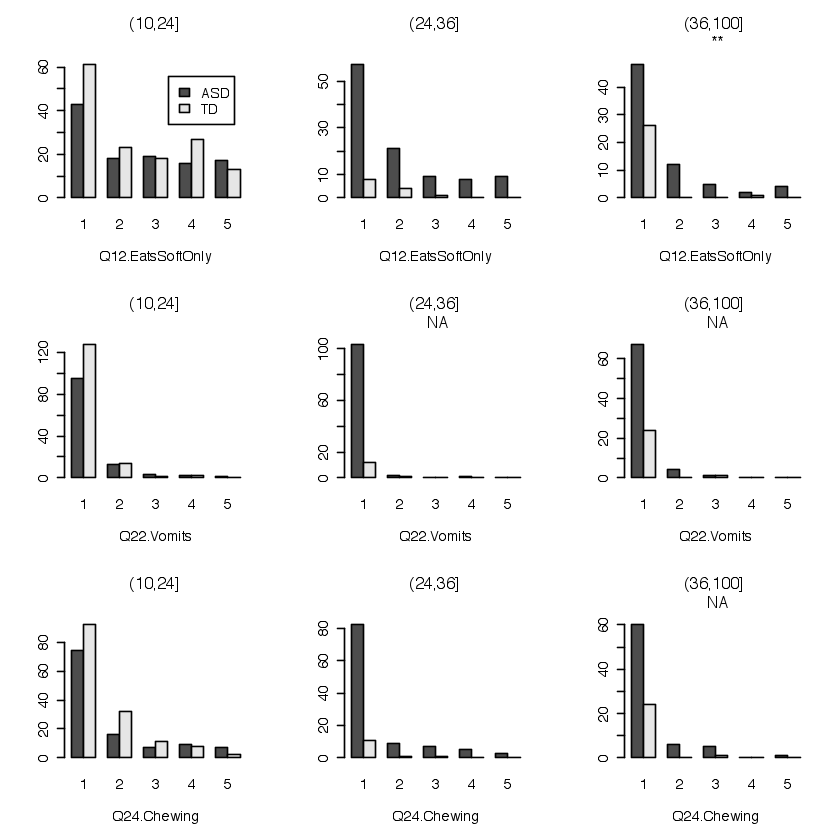

In [7]:
leg=TRUE
par(mfrow = c(3,length(overfitters)))
for(o in overfitters){
    #print(c('dxCode',o,'age_group') %in% colnames(Feed))
    tmp = na.omit(Feed[,c('dxCode',o,'age_group')])
    tab=table(tmp$dxCode,tmp[[o]],tmp$age_group) 
    for(i in 1:(dim(tab)[3])){
        p = chisq.test(tab[,,i])$p.value
        barplot( tab[,,i], beside = T,legend=leg,xlab=o,
                main=paste( dimnames(tab)[[3]][i]  ,'\n', ifelse(p>.1,'', ifelse(p>.05,'.', ifelse(p>.01,'**', '***'))) ))
        leg=FALSE
        #print(tab[,,i])
        #print( chisq.test(tab[,,i]))
    }
}

Figure X - histograms showing the severity of irregularity in food solidity, vomit and chewing. 

These variables were removed from the analysis because they induced overfitting in the final diagnosis group (36,100]. Each variable was likely overfit due to the lower sampling of TD combine with the low likelyhood of irregular behavior. We found it interesting that Q12 shows significant difference in ASD vs TD within the final diagnosis group. 

# Gastrointestinal Composite (GIC)

The Gastrointestinal Composite (GIC) is an aggregation of variables relating to GI distress including: constipation, diarrhea, gas, bloating, abdominal pain, belching, stool impact and reflux. Reflux variables were removed due to low variance but the other variables provide diverse insight into the degree of GI disorder frequently expirienced by the subject.

In [8]:
#GIvars = c('Q22.Vomits','Q23.Chokes','Q24.Chewing','Q27.Constip','Q28.Diarrhea','Q29.Gas','Q30.Bloat','Q31.AbdomPain','Q32.Blech','Q33.StoolImpact','Q34.Reflux')
GIvars = c('Q27.Constip','Q28.Diarrhea','Q29.Gas','Q30.Bloat','Q31.AbdomPain','Q32.Blech','Q33.StoolImpact','Q34.Reflux')
#GIvars = c('Q22.Vomits','Q23.Chokes','Q24.Chewing','Q27.Constip','Q29.Gas','Q30.Bloat','Q31.AbdomPain','Q32.Blech','Q33.StoolImpact','Q34.Reflux')
#colnames(Feed)[GIvars %in% colnames(Feed)]

## Unweighted GI Composite (uGIC)

The unweighted GI composite (uGIC) is simply a average of availiable GI survey questions that match minimum variance and reporting criteria; reflux was excluded. Each of the survey questions were converted to continuous numeric variables from 1 to 5 corresponding to "No GI distress" to "Extreme GI distress." uGIC ranges is [1,5] as it is the average of variables within the same bounds.

### Method of calculation
EDIT: NOW THE MEAN OF SCALED GI-VARS, THIS CHANGED THINGS A BIT

In [9]:

Feed$GIcomposite = apply(scale(Feed[,GIvars]),1,function(x) mean(na.omit(x)))
#keep = (!is.na(Feed$dxCode))&Feed$dxCode%in%c('ASD','TD')&Feed$AgeMo_Infant_feeding>0&Feed$AgeMo_Infant_feeding<30
#keep = (!is.na(Feed$dxCode))&Feed$dxCode%in%c('ASD','TD')&Feed$AgeMo_Infant_feeding>0&Feed$AgeMo_Infant_feeding<100
keep = (!is.na(Feed$dxCode))&Feed$dxCode%in%c('ASD','TD')&Feed$AgeMo_Infant_feeding>0&(!Feed$subjectid%in%bad_subj)
tmp = droplevels( Feed[keep,c('AgeMo_Infant_feeding','dxCode','GIcomposite','age_group')] )



Warning message:
: Removed 2 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 2 rows containing missing values (geom_point).

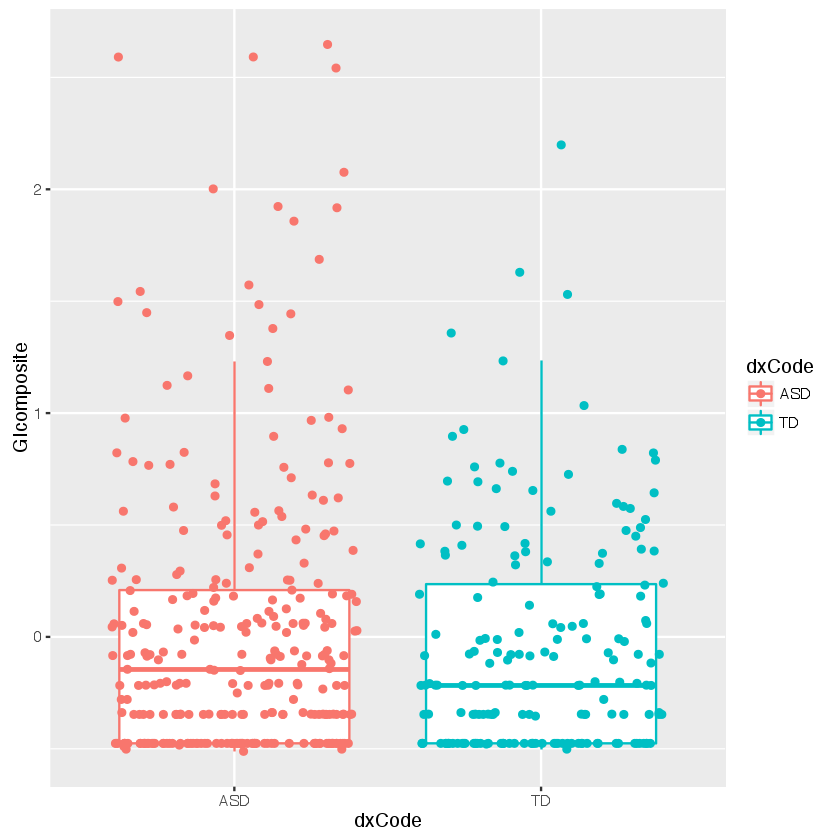

In [10]:
ggplot(data=tmp,aes(x=dxCode,y=GIcomposite,color=dxCode)) + geom_boxplot(outlier.shape = NA) + geom_jitter()

Warning message:
In grid.Call.graphics(L_polygon, x$x, x$y, index): semi-transparency is not supported on this device: reported only once per page

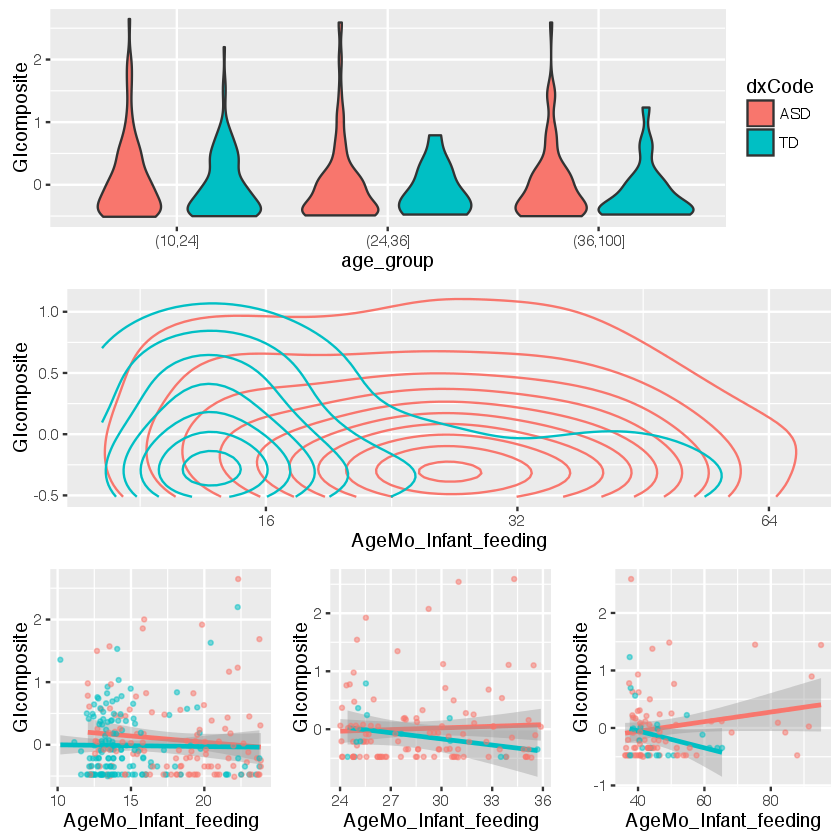

In [11]:
#ggplot(data=na.omit(tmp),aes(y=GIcomposite,color=AgeMo_Infant_feeding,x=dxCode))+  
# geom_boxplot(outlier.shape = NA)+ geom_jitter() + scale_colour_gradientn(colours=rainbow(4))

#thresh1 = 20
#thresh2 = 40
trans='identity'
#trans='log2'
    
g_box = ggplot(data=droplevels(na.omit(tmp)),aes(y=GIcomposite,x=age_group,fill=dxCode))+  
    geom_violin() #+ geom_jitter(size=.2)

#g_glm = ggplot(data=na.omit(tmp[tmp$AgeMo_Infant_feeding<100,]),aes(y=log(GIcomposite),x=AgeMo_Infant_feeding,color=dxCode))+ 
#    geom_point() + geom_smooth(aes(group=dxCode),method='glm')
    
g_loe = ggplot(data=na.omit(tmp[tmp$AgeMo_Infant_feeding<100,]),aes(y=GIcomposite,x=AgeMo_Infant_feeding,color=dxCode))+ 
    #geom_smooth(aes(group=dxCode),method='loess') +
    stat_density2d(h=1.1)+
    #geom_point(alpha=.5,size=.75) +  
    scale_y_continuous(trans=trans) + scale_x_continuous(trans='log2') + theme(legend.position='none')

g_glm_young = ggplot(data=na.omit(tmp[tmp$AgeMo_Infant_feeding<=thresh1,]),aes(y=GIcomposite,x=AgeMo_Infant_feeding,color=dxCode))+ 
    geom_smooth(aes(group=dxCode),method='glm') + geom_point(alpha=.5,size=.75) +  
    scale_y_continuous(trans=trans)+ theme(legend.position='none')

#g_loe_young = ggplot(data=na.omit(tmp[tmp$AgeMo_Infant_feeding<=thresh1,]),aes(y=log(GIcomposite),x=AgeMo_Infant_feeding,color=dxCode))+ 
#    geom_point() + geom_smooth(aes(group=dxCode),method='loess')

g_glm_old = ggplot(data=na.omit(tmp[tmp$AgeMo_Infant_feeding>thresh2,]),aes(y=GIcomposite,x=AgeMo_Infant_feeding,color=dxCode))+ 
    geom_smooth(aes(group=dxCode),method='glm') + geom_point(alpha=.5,size=.75) +  
    scale_y_continuous(trans=trans) + theme(legend.position='none')

#g_loe_old = ggplot(data=na.omit(tmp[tmp$AgeMo_Infant_feeding>thresh2,]),aes(y=log(GIcomposite),x=AgeMo_Infant_feeding,color=dxCode))+ 
#    geom_point() + geom_smooth(aes(group=dxCode),method='loess')

g_glm_mid = ggplot(data=na.omit(tmp[tmp$AgeMo_Infant_feeding<=thresh2&tmp$AgeMo_Infant_feeding>thresh1,]),aes(y=GIcomposite,x=AgeMo_Infant_feeding,color=dxCode))+ 
    geom_smooth(aes(group=dxCode),method='glm') + geom_point(alpha=.5,size=.75) +  
    scale_y_continuous(trans=trans) + theme(legend.position='none')

#g_loe_mid = ggplot(data=na.omit(tmp[tmp$AgeMo_Infant_feeding<=thresh2&tmp$AgeMo_Infant_feeding>thresh1,]),aes(y=log(GIcomposite),x=AgeMo_Infant_feeding,color=dxCode))+ 
#    geom_point() + geom_smooth(aes(group=dxCode),method='loess')

#grid.arrange(g_box, g_loe, ncol = 1)
#grid.arrange(g_box, g_glm, g_loe, ncol = 1)

#grid.arrange(g_box, g_glm, g_loe, g_glm_young, g_glm_mid,g_glm_old, g_loe_young, g_loe_mid,g_loe_old, ncol = 3, 
g=grid.arrange(g_box, g_loe, g_glm_young, g_glm_mid,g_glm_old, ncol = 3, 
             layout_matrix = rbind( c(1,1,1), 
                                    c(2,2,2),
                                    c(3,4,5) ))
ggsave(plot=g,filename = 'vis/uGIC_by_age.pdf',height=10,width=10)
ggsave(plot=g,filename = 'vis/uGIC_by_age.eps',height=10,width=10)



#### Figue X - Relation between ASD and TD over time. 
A. violin plots of the unweighted GI composite (uGIC). Subjects are split clinically relevant age groups: intake (10-24], Intermediate (24,36] and Final Diagnosis (36,100].  B. uGIC as a function of age in months. Both axis here are shrunken with log_2. A bivariate normal based kernal estimation procedure was used to generate the densities for ASD and TD groups across all ages. C Each age group is expanded and fit with generalized linear regressions for TD and ASD to examine the influence of age on uGIC within each age group.


#### Results: 
Figure X shows visualization of the uGIC scores. The violin plots in figure Xa plots suggest that the typical uGIC in often consistent between ASD and TD though the ASD group appears to be enriched for high uGIC scores. This is corroberated by ANOVA comparisons within each group (Suppliment SX. ANOVAs showed no significant difference in uGIC in any age group. This trend is again shown in the 2d desnity plots in Figure Xb. While TD uGIC appears to decrease over time, ASD uGIC appears to remain fairly constant.

When broken into three age groups: intake (10-24], Intermediate (24,36] and Final Diagnosis (36,100], seperate trends clearly emerge. The intake age ASD subject have a slightly higher average uGIC as confirmed by the marginally significant offset (ASD: beta=0.1,SE=0.06,p=.09) in the additive GLM model predicting uGIC from age and ASD (SuppX). In the intermediate and final diagnosis age groups, it is visually clear that many of the subjects with the highest uGIC are in the ASD group. Dispite the visualization, neither of these groups show statistical differences in slope or intercept when excluding subjects above age 70 months. When including subjects above 70 months of age, a positive coefficient of interaction between age and uGIC becomes marginally significant; this is the basis for an extrapolative finding that higher age ASD individuals have higher uGIC (ASD*age: beta=0.02,SE=0.01,p=0.08). Additionally there is a significant increase in likelihood between the adative and interaction model (SuppX). This finding is corroberated by the literature [...].

In [12]:
#ggplot(data=droplevels(na.omit(tmp)),aes(y=GIcomposite,x=age_group,fill=dxCode))+  
# geom_boxplot(outlier.shape = NA)+ geom_jitter() # + scale_colour_gradientn(colours=rainbow(4))

tmp$dxCode = factor(tmp$dxCode,levels=c('TD','ASD'))

for(i in levels(tmp$age_group)){
    print('################  ANOVA  #######################')
    print(i)
    
    # basic anova
    print(summary( aov(GIcomposite ~ dxCode , data=tmp[tmp$age_group==i,] ) ))
    
    print('----------------------------')
}

for(i in levels(tmp$age_group)){
    print('################  GLM  #######################')
    print(i)
    
    # addative and interaction models
    mod1=glm( GIcomposite~ dxCode+AgeMo_Infant_feeding , data=tmp[tmp$age_group==i,] ) 
    mod2=glm( GIcomposite~ dxCode*AgeMo_Infant_feeding , data=tmp[tmp$age_group==i,] ) 
    
    print(summary(mod1))
    print(summary(mod2))
    print(anova(mod1,mod2,test='LRT'))
    
    print('----------------------------')
}

tmp$dxCode = factor(tmp$dxCode,levels=c('ASD','TD'))

[1] "################  ANOVA  #######################"
[1] "(10,24]"
             Df Sum Sq Mean Sq F value Pr(>F)
dxCode        1   0.61  0.6118   1.921  0.167
Residuals   257  81.84  0.3184               
2 observations deleted due to missingness
[1] "----------------------------"
[1] "################  ANOVA  #######################"
[1] "(24,36]"
             Df Sum Sq Mean Sq F value Pr(>F)
dxCode        1   0.16  0.1588   0.411  0.523
Residuals   117  45.18  0.3862               
2 observations deleted due to missingness
[1] "----------------------------"
[1] "################  ANOVA  #######################"
[1] "(36,100]"
            Df Sum Sq Mean Sq F value Pr(>F)
dxCode       1   0.44  0.4398   1.377  0.244
Residuals   94  30.01  0.3193               
4 observations deleted due to missingness
[1] "----------------------------"
[1] "################  GLM  #######################"
[1] "(10,24]"

Call:
glm(formula = GIcomposite ~ dxCode + AgeMo_Infant_feeding, data = tmp[tmp$ag

###  Assosiation Between ASD and uGIC over time by group (SuppX)



In [13]:
DONT RUN
tmp_orig = tmp
family='binomial'

tmp2=na.omit(tmp_orig)
#pred=tmp$GIcomposite
#truth=ifelse(tmp$dxCode=='ASD',1,0) 
#pred_assess(resp='dxCode',pred=pred,truth=truth,xlim=c(0,1),ylim=c(0,1))
out=cross_valid_kfold(data=tmp2,formula=as.formula('dxCode~GIcomposite'),resp='dxCode',family,K=2,model=glm)
# assessment
pred_assess(resp='dxCode',pred=out$pred_out,truth=out$labels_out)  

for(i in 1:length(levels(tmp$age_group))){
    # performance
    tmp2=na.omit(tmp_orig[tmp_orig$age_group==levels(tmp_orig$age_group)[i],])
#    pred=tmp$GIcomposite
#    truth=ifelse(tmp$dxCode=='ASD',1,0) 
#    pred_assess(resp='dxCode',pred=pred,truth=truth,xlim=c(0,1),ylim=c(0,1)) 
    
    out=cross_valid_kfold(data=tmp2,formula=as.formula('dxCode~GIcomposite'),resp='dxCode',family,K=2,model=glm)
    # assessment
    pred_assess(resp='dxCode',pred=out$pred_out,truth=out$labels_out)  
}

ERROR: Error in parse(text = x, srcfile = src): <text>:1:6: unexpected symbol
1: DONT RUN
         ^


# Infant Feed Survey

In [14]:
FeedVars = colnames(Feed)[ grepl('Q|AgeMo_Infant',colnames(Feed)) ]
FeedVars = FeedVars[!FeedVars%in%bad_vars]
keep = (!is.na(Feed$dxCode))&Feed$dxCode%in%c('ASD','TD')&Feed$AgeMo_Infant_feeding>0&Feed$AgeMo_Infant_feeding<70&(!Feed$subjectid%in%bad_subj)
Feed$dxCode = factor(as.character(Feed$dxCode),levels=c('TD','ASD'))
Feed=Feed[keep,]

## Regression Model of Feed Variables

In [15]:
table(Feed$age_group,Feed$dxCode)

          
            TD ASD
  (10,24]  145 114
  (24,36]   13 106
  (36,100]  26  65

In [16]:
vis_screen = list()
vis_final  = list()
vis_perf   = list()

In [17]:
p=.15
K=5
N=3

pdf('vis/all_var_mod.age_group_sep.PERFORMANCE.pdf')
##################
print('AGE GROUPS: ALL')
Feed_tmp = Feed
mod=model_selection(df=Feed_tmp,observations=FeedVars,response='dxCode',family='binomial',model=glm,interactions=FALSE,test='LRT',thresh_screen=p,K=K,N=N,only_return_selected=FALSE)
vis=vis_logit(mod,intercept = FALSE)
vis_screen[['ALL']] = vis[[2]]
vis_final[['ALL']] = vis[[1]]

##################
print('AGE GROUPS: INTAKE')
Feed_tmp = Feed[ as.numeric(Feed$age_group)==1, ]
mod=model_selection(df=Feed_tmp,observations=FeedVars,response='dxCode',family='binomial',model=glm,interactions=FALSE,test='LRT',thresh_screen=p,K=K,N=N,only_return_selected=FALSE)
vis=vis_logit(mod,intercept = FALSE)
vis_screen[['INTAKE']] = vis[[2]]
vis_final[['INTAKE']] = vis[[1]]

##################
print('AGE GROUPS: INTERMEDIATE')
Feed_tmp = Feed[ as.numeric(Feed$age_group)==2, ]
mod=model_selection(df=Feed_tmp,observations=FeedVars,response='dxCode',family='binomial',model=glm,interactions=FALSE,test='LRT',thresh_screen=p,K=K-1,N=N,only_return_selected=FALSE)
vis=vis_logit(mod,intercept = FALSE)
vis_screen[['INTERMEDIATE']] = vis[[2]]
vis_final[['INTERMEDIATE']] = vis[[1]]

##################
print('AGE GROUPS: FINAL DIAGNOSIS')
Feed_tmp = Feed[ as.numeric(Feed$age_group)==3, ]
mod=model_selection(df=Feed_tmp,observations=FeedVars,response='dxCode',family='binomial',model=glm,interactions=FALSE,test='LRT',thresh_screen=p-.1,K=K-1,N=N+1,only_return_selected=FALSE)
vis=vis_logit(mod,intercept = FALSE)
vis_screen[['FINAL_DX']] = vis[[2]]
vis_final[['FINAL_DX']] = vis[[1]]

####################
dev.off()

[1] "AGE GROUPS: ALL"
[1] "Q01.NewFoods"
[1] "Q02.EnjoysEating"
[1] "Q03.PoorAppetite"
[1] "Q04.EatsTooMuch"
[1] "Q05.EatsTooLittle"
[1] "Q06.FeedCry"
[1] "Q07.MealTantrum"
[1] "Q08.MealGT20Min"
[1] "Q09.FoodSitMouth"
[1] "Q10.FoodSpit"
[1] "Q11.MealRefuse"
[1] "Q13.EatsVeg"
[1] "Q14.EatsMeatFish"
[1] "Q15.EatsStarches"
[1] "Q16.EatsFruits"
[1] "Q17.EatsSnacks"
[1] "Q18.EatsCereals"
[1] "Q19.DrinksMilk"
[1] "Q20.PreferDrink"
[1] "Q23.Chokes"
[1] "Q27.Constip"
[1] "Q28.Diarrhea"
[1] "Q29.Gas"
[1] "Q30.Bloat"
[1] "Q31.AbdomPain"
[1] "Q32.Blech"
[1] "Q33.StoolImpact"
[1] "Q38.FoodAllergies"
[1] "AgeMo_Infant_feeding"
Start:  AIC=477.42
dxCode ~ Q01.NewFoods + Q02.EnjoysEating + Q07.MealTantrum + 
    Q08.MealGT20Min + Q09.FoodSitMouth + Q11.MealRefuse + Q13.EatsVeg + 
    Q14.EatsMeatFish + Q15.EatsStarches + Q16.EatsFruits + Q17.EatsSnacks + 
    Q18.EatsCereals + Q20.PreferDrink + Q28.Diarrhea + Q30.Bloat + 
    Q31.AbdomPain + AgeMo_Infant_feeding

                       Df Deviance   

Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be 

[1] "AGE GROUPS: INTAKE"
[1] "Q01.NewFoods"
[1] "Q02.EnjoysEating"
[1] "Q03.PoorAppetite"
[1] "Q04.EatsTooMuch"
[1] "Q05.EatsTooLittle"
[1] "Q06.FeedCry"
[1] "Q07.MealTantrum"
[1] "Q08.MealGT20Min"
[1] "Q09.FoodSitMouth"
[1] "Q10.FoodSpit"
[1] "Q11.MealRefuse"
[1] "Q13.EatsVeg"
[1] "Q14.EatsMeatFish"
[1] "Q15.EatsStarches"
[1] "Q16.EatsFruits"
[1] "Q17.EatsSnacks"
[1] "Q18.EatsCereals"
[1] "Q19.DrinksMilk"
[1] "Q20.PreferDrink"
[1] "Q23.Chokes"
[1] "Q27.Constip"
[1] "Q28.Diarrhea"
[1] "Q29.Gas"
[1] "Q30.Bloat"
[1] "Q31.AbdomPain"
[1] "Q32.Blech"
[1] "Q33.StoolImpact"
[1] "Q38.FoodAllergies"
[1] "AgeMo_Infant_feeding"
Start:  AIC=268.95
dxCode ~ Q01.NewFoods + Q03.PoorAppetite + Q07.MealTantrum + 
    Q08.MealGT20Min + Q13.EatsVeg + Q14.EatsMeatFish + Q15.EatsStarches + 
    Q16.EatsFruits + Q17.EatsSnacks + Q27.Constip + Q28.Diarrhea + 
    Q33.StoolImpact + AgeMo_Infant_feeding

                       Df Deviance    AIC
- Q27.Constip           1   240.97 266.97
- Q17.EatsSnacks       

Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be 

[1] "AGE GROUPS: INTERMEDIATE"
[1] "Q01.NewFoods"
[1] "Q02.EnjoysEating"
[1] "Q03.PoorAppetite"
[1] "Q04.EatsTooMuch"
[1] "Q05.EatsTooLittle"
[1] "Q06.FeedCry"
[1] "Q07.MealTantrum"
[1] "Q08.MealGT20Min"
[1] "Q09.FoodSitMouth"
[1] "Q10.FoodSpit"
[1] "Q11.MealRefuse"
[1] "Q13.EatsVeg"
[1] "Q14.EatsMeatFish"
[1] "Q15.EatsStarches"
[1] "Q16.EatsFruits"
[1] "Q17.EatsSnacks"
[1] "Q18.EatsCereals"
[1] "Q19.DrinksMilk"
[1] "Q20.PreferDrink"
[1] "Q23.Chokes"
[1] "Q27.Constip"
[1] "Q28.Diarrhea"
[1] "Q29.Gas"
[1] "Q30.Bloat"
[1] "Q31.AbdomPain"
[1] "Q32.Blech"
[1] "Q33.StoolImpact"
[1] "Q38.FoodAllergies"
[1] "AgeMo_Infant_feeding"
Start:  AIC=79.79
dxCode ~ Q13.EatsVeg + Q15.EatsStarches + Q16.EatsFruits + Q18.EatsCereals + 
    Q23.Chokes

                   Df Deviance    AIC
- Q16.EatsFruits    1   67.807 77.807
- Q15.EatsStarches  1   67.951 77.951
<none>                  67.788 79.788
- Q18.EatsCereals   1   69.823 79.823
- Q23.Chokes        1   70.093 80.093
- Q13.EatsVeg       1   72.71

Warning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWaiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for prof

[1] "AGE GROUPS: FINAL DIAGNOSIS"
[1] "Q01.NewFoods"
[1] "Q02.EnjoysEating"
[1] "Q03.PoorAppetite"
[1] "Q04.EatsTooMuch"
[1] "Q05.EatsTooLittle"
[1] "Q06.FeedCry"
[1] "Q07.MealTantrum"
[1] "Q08.MealGT20Min"
[1] "Q09.FoodSitMouth"
[1] "Q10.FoodSpit"
[1] "Q11.MealRefuse"
[1] "Q13.EatsVeg"
[1] "Q14.EatsMeatFish"
[1] "Q15.EatsStarches"
[1] "Q16.EatsFruits"
[1] "Q17.EatsSnacks"
[1] "Q18.EatsCereals"
[1] "Q19.DrinksMilk"
[1] "Q20.PreferDrink"
[1] "Q23.Chokes"
[1] "Q27.Constip"
[1] "Q28.Diarrhea"
[1] "Q29.Gas"
[1] "Q30.Bloat"
[1] "Q31.AbdomPain"
[1] "Q32.Blech"
[1] "Q33.StoolImpact"
[1] "Q38.FoodAllergies"
[1] "AgeMo_Infant_feeding"
Start:  AIC=76.76
dxCode ~ Q01.NewFoods + Q03.PoorAppetite + Q06.FeedCry + Q07.MealTantrum + 
    Q09.FoodSitMouth + Q10.FoodSpit + Q13.EatsVeg + Q14.EatsMeatFish + 
    Q15.EatsStarches + Q16.EatsFruits + Q17.EatsSnacks + Q20.PreferDrink + 
    Q23.Chokes

                   Df Deviance    AIC
- Q16.EatsFruits    1   48.817 74.817
- Q14.EatsMeatFish  1   48.875 7

Warning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWaiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for 

pdf 
  2

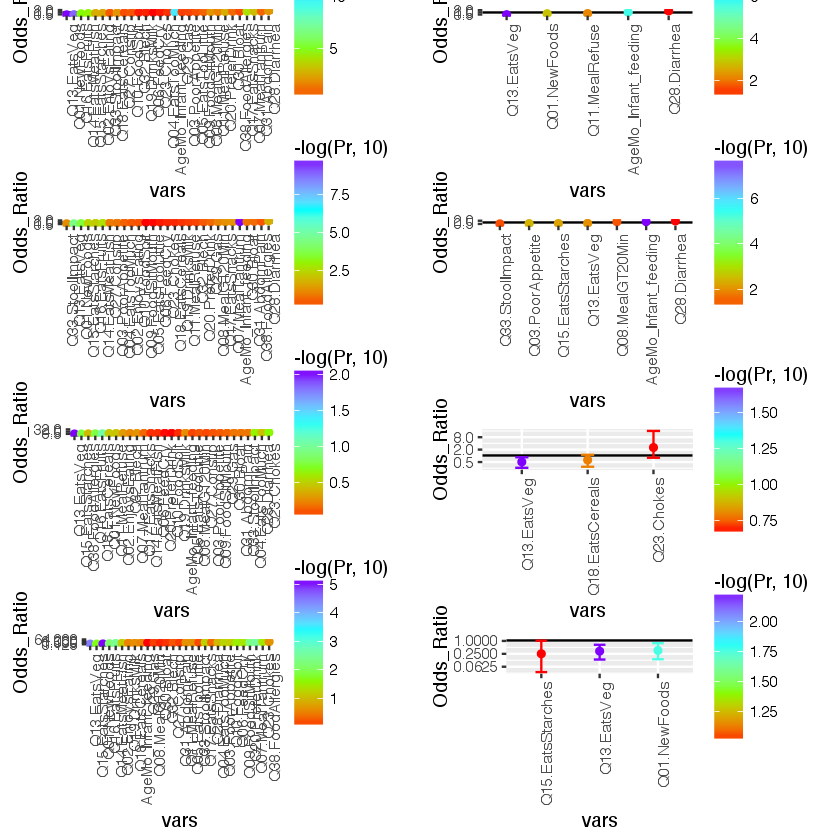

In [18]:
g=grid.arrange(vis_screen[[1]], vis_screen[[2]], vis_screen[[3]], vis_screen[[4]],
               vis_final[[1]], vis_final[[2]], vis_final[[3]],vis_final[[4]],
               #vis_perf[[1]], vis_perf[[2]], vis_perf[[3]],vis_perf[[4]],
            ncol = 3, layout_matrix=matrix(1:8,nrow=4,ncol=2))
            #layout_matrix = rbind( c(1,2,3), c(4,5,6), c(7,8,9) ))
system('ls')
ggsave(plot=g,filename = 'vis/all_var_mod.age_group_sep.eps',height=15,width=10)

Figure X - Univariate and Multivariate regression models for all, intake, intermediate and final diagnosis age children
Figure X - Performance plots for all, intake, intermediate and final diagnosis age children including: ROC, PPV vs NPV, Precision-Recall and Matthew's Correlation Coefficient.

These figures show several significant feeding behavior related distinctions between ASD and TD. 

#### Results
Across all age groups, Figure Xa-b, vegitable and novel food consumption are most strongly associated with typical development. Interestingly, meal refusal and diariah are both found to be autism risk factors in the univariate model screenings (figure Xa) though only diariah maintains a marginal risk status in the multivariate model (figure Xb); the  statistical protection of meal refusal in the final model is likely due to the anti-correlation between meal refusal and meal exploration (vegitable and novel food consumption). After accounting for meal exploration, it appears that meal refusal is a protective indicator. The model for all age groups performs well with and AUC, PPV and Percision close to 0.8, and an MCC close to 0.5. The low standard deviation within these performance statistics suggests these models are not overfit.

These associations were also examined across age groups. These models help to identify the individual age groups that contribute most to each association. Diarrea as an autism risk factor appears to be specific to intake age children (figure Xd). The protection confirred by consumption of new foods appears to be an association specific to final diagnosis age subjects (figure Xh). New food consumption also shows a singificant protective effect in the univariate models (figure Xc) for the intake age children though it was not included in the multivariate model (figure Xd). Meal refusal is not a significant contributor to in the univariate or multivariate models of any individual age group.  Noteably, the protective effect of vegitable consumption is significant and high magnitude in all age groups; the magnitude of this effect appears to increase with age (figure Xb,Xd,Xf,Xh).

#### Methods: Regression Modeling
RegressionModelPipeline was used to generate generalized linear models (GLM) representing univariate models for each variable of interest. Variables with a marginal significant association with ASD (p<.2) were selected and combined into a multivariate model which was pruned using backwards elimination (BE) to produce a final addivite multivariate model.

## Regression Model of Feed Variables, CSBS Controlled

In [19]:
FeedVars = FeedVars[! FeedVars %in% bad_vars ]

mod1=list() ; mod0=list() ; Pr = c() ; tmp_dat=list()
Feed_tmp = na.omit( Feed[,c('dxCode',FeedVars,'CSBS_Total_1_perMo_factor')] )
print(table(Feed$dxCode))
print(table(Feed_tmp$dxCode))



 TD ASD 
185 286 

 TD ASD 
126 132 


In [ ]:

for(i in FeedVars){
    #tmp_dat[[i]] = na.omit( Feed[,c('dxCode',i,'CSBS_Total_1_perMo_factor')] )
    mod0[[i]]=glmer(dxCode ~ (1|CSBS_Total_1_perMo_factor) , data=Feed_tmp , family=binomial)
    mod1[[i]]=glmer(as.formula(paste('dxCode ~',i,'+ (1|CSBS_Total_1_perMo_factor)')) , data=Feed_tmp , family=binomial)
    Pr[i]=anova(mod1[[i]],mod0[[i]],test='LRT')[2,8]
    #print( summary(mod1[[i]]) )
}
attr(mod1,'Pr') = Pr
vis_out = vis(out=list(screen=mod1,final=NULL))

Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...


In [ ]:
print(table(Feed_tmp$dxCode,Feed_tmp$CSBS_Total_1_perMo_factor))

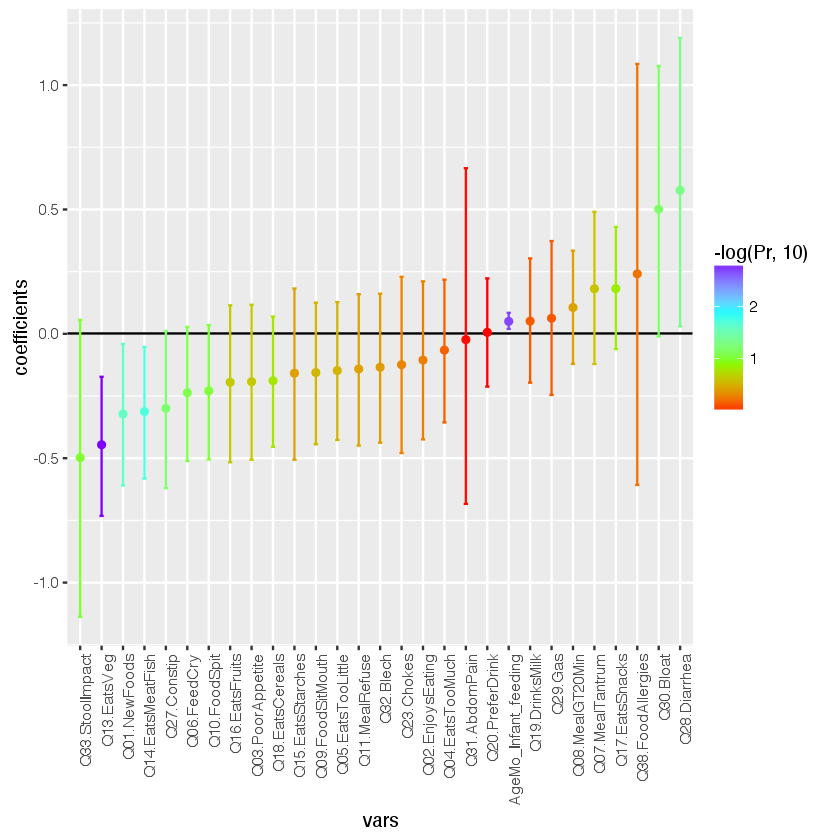

In [40]:
#vis_lme(mod1)
vis_out$univar

Figure X - Univariate regression models describing the association between ASD and various feeding behaviors while controling for prior likelyhood of ASD onset. 

#### Method: Examining Feeding Variables while controlling for ASD onset likelihood
Model selection was performed as described in the previous section. Univariate modeling followed by backwards selection on a multivariate model containing all marginally significant variables. These models are unique becuase they account for prior likelihood of ASD onset using the age normalized CSBS evaluation. These model describe differentiating factors between ASD and TD within CSBS groups: 
- high risk = 0 - 1.5 CSBS total / month: TD 11, ASD 73
- ambiguous risk = 1.5 - 2.5 CSBS total / month: TD 78, ASD 48
- low risk = 2.5 - 5 CSBS total / month: TD 37, ASD 11
Therefore, this is similar, to an experiment controlling for prior likelihood of ASD. We approximately ask the question: "What factors modify the likelihood of ASD onset independent of the likelihood of ASD.

#### Results: Examining Feeding Variables while controlling for ASD onset likelihood
Vegitable consumption remains the most robust ASD protective effect with an odds ratio of nearly .5 while novel food exploration and diarrhea are again found to be marginally protective and deleterious respectively. Additionally, protein consumption is found to be marginally significant.

Because these models control for prior likelihood of ASD onset, we beleive these models suggest that these effects, vegitable consumption in particular, may be independent influencers of ASD onset.

Estimate Std. Error    z value    Pr(>|z|)
(Intercept)           3.40402725 1.53003056  2.2248100 0.026093997
Q01.NewFoods         -0.16196854 0.17368702 -0.9325310 0.351062162
Q06.FeedCry          -0.20481891 0.15257394 -1.3424239 0.179458577
Q10.FoodSpit         -0.34185186 0.15769781 -2.1677654 0.030176538
Q13.EatsVeg          -0.53879529 0.17746093 -3.0361347 0.002396323
Q14.EatsMeatFish     -0.07609623 0.17755958 -0.4285673 0.668238140
Q27.Constip          -0.27881905 0.19186566 -1.4531993 0.146168413
Q28.Diarrhea          0.67695915 0.30487906  2.2204186 0.026390363
Q30.Bloat             0.30392791 0.29812602  1.0194612 0.307984056
Q33.StoolImpact      -0.36832103 0.35041839 -1.0510893 0.293217565
AgeMo_Infant_feeding  0.03867725 0.01744513  2.2170800 0.026617622

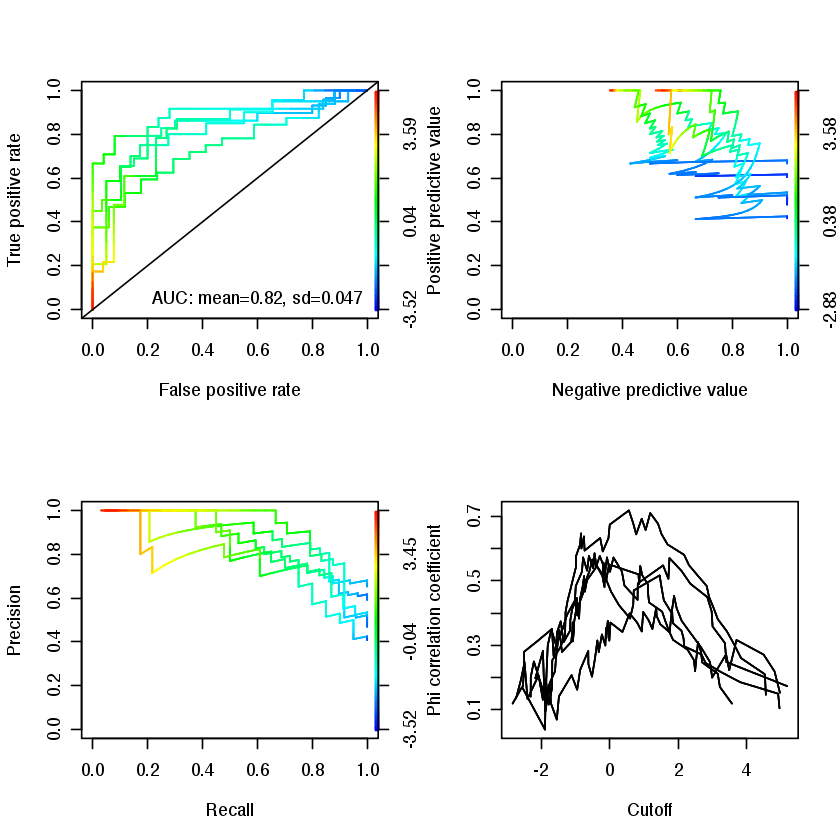

In [127]:
# construct complete model
form = as.formula(paste('dxCode ~',paste(names(mod1)[attr(mod1,'Pr')<.1],collapse='+'),'+ (1|CSBS_Total_1_perMo_factor)'))
Feed_tmp = na.omit( Feed[,all.vars(form)] )
complete_mod = glmer(form , data=Feed_tmp , family=binomial)
coef(summary(complete_mod))
  
# measure performance of complete model
resp = all.vars(form)[1]
# cross validation
out = cross_valid_kfold(data=Feed_tmp,formula=form,resp=resp,family=binomial,K=5,N=3,model=glmer)
# assessment
pred_out = pred_assess(resp=resp,pred=out$pred_out,truth=out$labels_out,xlim=c(0,1),ylim=c(0,1))

In [128]:
# Backward Elimination
library(MuMIn)

print('4 variables')
    mC<-glmer(dxCode ~ Q13.EatsVeg+Q28.Diarrhea+AgeMo_Infant_feeding +Q01.NewFoods + (1|CSBS_Total_1_perMo_factor)  , data=Feed_tmp , family=binomial)
    m1<-glmer(dxCode ~ Q28.Diarrhea+AgeMo_Infant_feeding +Q01.NewFoods + (1|CSBS_Total_1_perMo_factor)  , data=Feed_tmp , family=binomial)
    m2<-glmer(dxCode ~ Q13.EatsVeg+AgeMo_Infant_feeding +Q01.NewFoods + (1|CSBS_Total_1_perMo_factor)  , data=Feed_tmp , family=binomial)
    m3<-glmer(dxCode ~ Q13.EatsVeg+Q28.Diarrhea +Q01.NewFoods + (1|CSBS_Total_1_perMo_factor)  , data=Feed_tmp , family=binomial)
    m4<-glmer(dxCode ~ Q13.EatsVeg+Q28.Diarrhea+AgeMo_Infant_feeding + (1|CSBS_Total_1_perMo_factor)  , data=Feed_tmp , family=binomial)
model.sel(mC,m1,m2,m3,m4,rank=AIC)
anova(mC,m4,test='LRT')
print('3 variables')
    mC<-glmer(dxCode ~ Q13.EatsVeg+Q28.Diarrhea+AgeMo_Infant_feeding + (1|CSBS_Total_1_perMo_factor)  , data=Feed_tmp , family=binomial)
    m1<-glmer(dxCode ~ Q13.EatsVeg+Q28.Diarrhea + (1|CSBS_Total_1_perMo_factor)  , data=Feed_tmp , family=binomial)
    m2<-glmer(dxCode ~ Q13.EatsVeg+AgeMo_Infant_feeding + (1|CSBS_Total_1_perMo_factor)  , data=Feed_tmp , family=binomial)
    m3<-glmer(dxCode ~ Q28.Diarrhea+AgeMo_Infant_feeding + (1|CSBS_Total_1_perMo_factor)  , data=Feed_tmp , family=binomial)
model.sel(mC,m1,m2,m3,rank=AIC)
anova(mC,m2,test='LRT')
print('mC -> m2 give a significant loss p=.01')
print('Final model: dxCode ~ Q13.EatsVeg+Q28.Diarrhea+AgeMo_Infant_feeding + (1|CSBS_Total_1_perMo_factor)')

print('minimal model examination')
    mC<-glmer(dxCode ~ Q13.EatsVeg+AgeMo_Infant_feeding + (1|CSBS_Total_1_perMo_factor)  , data=Feed_tmp , family=binomial)
    m1<-glmer(dxCode ~ Q13.EatsVeg + (1|CSBS_Total_1_perMo_factor)  , data=Feed_tmp , family=binomial)
    m2<-glmer(dxCode ~ AgeMo_Infant_feeding + (1|CSBS_Total_1_perMo_factor)  , data=Feed_tmp , family=binomial)
model.sel(mC,m1,m2,rank=AIC)
print('cannot be further reduced without extreme loss of significance')

[1] "4 variables"


Model selection table 
      (Int) AgM_Inf_fdn Q01.NwF Q13.EtV Q28.Drr df   logLik   AIC delta weight
m4  0.01029     0.05828         -0.4637  0.6487  5 -146.833 303.7  0.00  0.649
mC  0.30400     0.05581 -0.1015 -0.4300  0.6397  6 -146.631 305.3  1.60  0.292
m2  1.17700     0.05359 -0.1113 -0.4398          5 -149.489 309.0  5.31  0.046
m1 -0.69870     0.05117 -0.2718          0.6476  5 -150.846 311.7  8.03  0.012
m3  1.73700             -0.2336 -0.3746  0.5623  5 -152.690 315.4 11.71  0.002
Models ranked by AIC(x) 
Random terms (all models): 
‘1 | CSBS_Total_1_perMo_factor’

Data: Feed_tmp
Models:
m4: dxCode ~ Q13.EatsVeg + Q28.Diarrhea + AgeMo_Infant_feeding + 
m4:     (1 | CSBS_Total_1_perMo_factor)
mC: dxCode ~ Q13.EatsVeg + Q28.Diarrhea + AgeMo_Infant_feeding + 
mC:     Q01.NewFoods + (1 | CSBS_Total_1_perMo_factor)
   Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)
m4  5 303.67 322.08 -146.83   293.67                         
mC  6 305.26 327.36 -146.63   293.26 0.4043      1     0.5249

[1] "3 variables"


Model selection table 
      (Int) AgM_Inf_fdn Q13.EtV Q28.Drr df   logLik   AIC delta weight
mC  0.01029     0.05828 -0.4637  0.6487  5 -146.833 303.7  0.00  0.862
m2  0.86740     0.05634 -0.4773          4 -149.739 307.5  3.81  0.128
m3 -1.84300     0.05786          0.6771  4 -152.608 313.2  9.55  0.007
m1  1.18500             -0.4524  0.5732  4 -153.878 315.8 12.09  0.002
Models ranked by AIC(x) 
Random terms (all models): 
‘1 | CSBS_Total_1_perMo_factor’

Data: Feed_tmp
Models:
m2: dxCode ~ Q13.EatsVeg + AgeMo_Infant_feeding + (1 | CSBS_Total_1_perMo_factor)
mC: dxCode ~ Q13.EatsVeg + Q28.Diarrhea + AgeMo_Infant_feeding + 
mC:     (1 | CSBS_Total_1_perMo_factor)
   Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)  
m2  4 307.48 322.21 -149.74   299.48                           
mC  5 303.67 322.08 -146.83   293.67 5.8117      1    0.01592 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

[1] "mC -> m2 give a significant loss p=.01"
[1] "Final model: dxCode ~ Q13.EatsVeg+Q28.Diarrhea+AgeMo_Infant_feeding + (1|CSBS_Total_1_perMo_factor)"
[1] "minimal model examination"


Model selection table 
     (Int) AgM_Inf_fdn Q13.EtV df   logLik   AIC delta weight
mC  0.8674     0.05634 -0.4773  4 -149.739 307.5  0.00  0.992
m2 -1.0150     0.05647          3 -156.084 318.2 10.69  0.005
m1  1.9320             -0.4690  3 -156.370 318.7 11.26  0.004
Models ranked by AIC(x) 
Random terms (all models): 
‘1 | CSBS_Total_1_perMo_factor’

[1] "cannot be further reduced without extreme loss of significance"


Estimate Std. Error     z value     Pr(>|z|)
(Intercept)           0.06026309 1.01155826  0.05957451 0.9524945215
Q13.EatsVeg          -0.48989604 0.13620490 -3.59675782 0.0003222082
Q28.Diarrhea          0.60153523 0.27226241  2.20939512 0.0271471701
AgeMo_Infant_feeding  0.06257005 0.01666531  3.75450948 0.0001736813

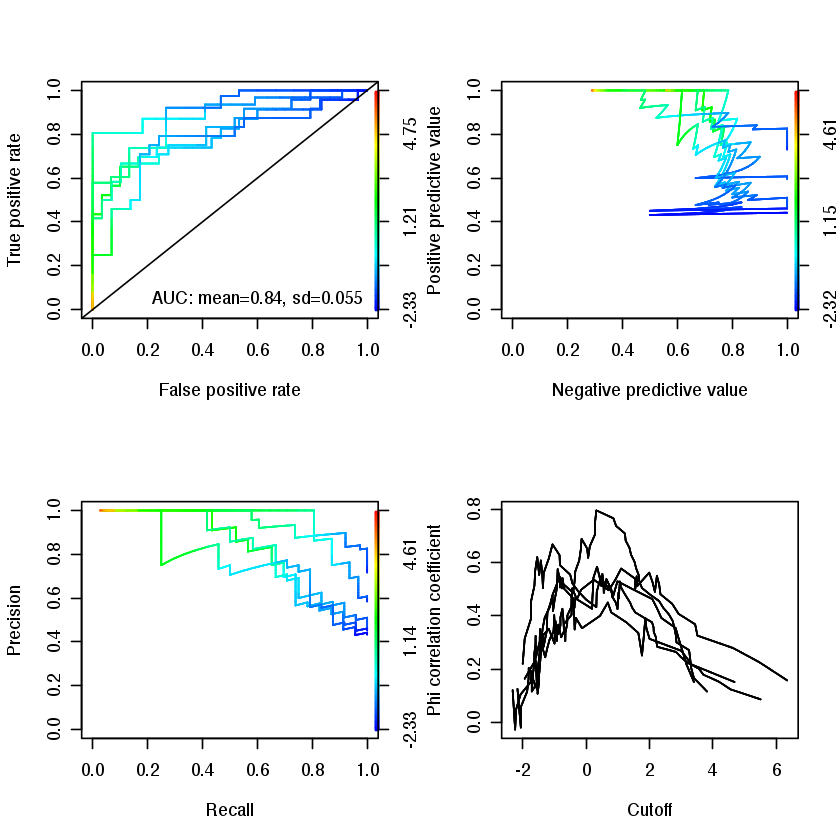

In [130]:
# backward selection 3
form_final_3 = dxCode ~ Q13.EatsVeg+Q28.Diarrhea+AgeMo_Infant_feeding + (1|CSBS_Total_1_perMo_factor)
final_mod_3 = glmer(form_final_3  , data=Feed_tmp , family=binomial)
coef(summary(final_mod_3))

# measure performance of back selection model 3
form = form_final_3
Feed_tmp = na.omit( Feed[,all.vars(form)] )
resp = all.vars(form)[1]
# cross validation
out = cross_valid_kfold(data=Feed_tmp,formula=form,resp=resp,family=binomial,K=5,N=4,model=glmer)
# assessment
pred_out=pred_assess(resp=resp,pred=out$pred_out,truth=out$labels_out,xlim=c(0,1),ylim=c(0,1)) 

#### Multivariate Model Selection for CSBS GLMER
To acheive a similar level of performance at ASD prediction we need only consider consumption of vegitables, diarrhea and infant age. According to the backwards elimination, diarrhea is not an essential member of the final model but it is included as it cannot be removed without inducing a significant decrease in likelihood.

# Fruit and Vegetable Diversity and Nutrient Profile

#### Motivation: Color as a nutritional and therefore microbiome health correlate
In the previous section, we observed that vegitable consumption is associated with ASD onset. This was the most robust effect observed and appears to even be independent of prior expectation of ASD. Considering recent interest in the relevance of the gut microbiome to ASD and the relation of vegitable diversity to a healthy gut microbiome (American Gut), we endevoured to examine if vegitable diversity was also associated with likelihood of NEC onset. If vegitable diversity is associated with ASD and a healthy gut microbiome, then low vegitable diversity may be an opportunity for a child to increase their likelihood on ASD onset.

We use color here to approximate the diversity of nutrition and vegitables consumed by each child. Our intention is to demonstrate that children consuming a greater diversity of fruits and vegitables and the associate nutrition have a differential association with ASD. The expectation that nutritional diversity may drive microbiome diversity and therefore confer a relation in that manner comes from work done by the American Gut project; they recently found that the best correlate to microbiome diversity is vegitable (diversity?) consumption.

#### Methods: Determining each measure of color and proxy nutrition
.... Ahmed

#### Shortcoming: 
If a child is more open to trying new foods, they are more likely to consume a broader diversity of vegitables therefore this may be the re-iteration of the "New foods" signal discovered in section X.

## Regression Model of Fruit and Vegetable Diversity

[1] "Diversity.Green.Veggies.and.Fruits"          
[2] "Diversity.Red.Veggies.and.Fruits"            
[3] "Diversity.Yellow.Orange.Veggies.and.Fruits"  
[4] "Diversity.White.Tan.Brown.Veggies.and.Fruits"
[5] "Diversity.Purple.Blue.Veggies.and.Fruits"    
[6] "Binary.Diversity"                            
[7] "Robust.Binary.Diversity"                     
[8] "Continuous.Diversity"                        
[9] "Normalized.Continuous.Diversity"


 TD ASD 
186 293 

[1] "Diversity.Green.Veggies.and.Fruits"
[1] "Diversity.Red.Veggies.and.Fruits"
[1] "Diversity.Yellow.Orange.Veggies.and.Fruits"
[1] "Diversity.White.Tan.Brown.Veggies.and.Fruits"
[1] "Diversity.Purple.Blue.Veggies.and.Fruits"
[1] "Binary.Diversity"
[1] "Robust.Binary.Diversity"
[1] "Continuous.Diversity"
[1] "Normalized.Continuous.Diversity"
Start:  AIC=643.14
dxCode ~ Diversity.Green.Veggies.and.Fruits + Diversity.White.Tan.Brown.Veggies.and.Fruits + 
    Binary.Diversity + Robust.Binary.Diversity + Continuous.Diversity + 
    Normalized.Continuous.Diversity

                                               Df Deviance    AIC
- Continuous.Diversity                          1   629.15 641.15
- Normalized.Continuous.Diversity               1   629.19 641.19
- Robust.Binary.Diversity                       1   629.21 641.21
- Binary.Diversity                              1   629.24 641.24
- Diversity.Green.Veggies.and.Fruits            1   630.11 642.11
<none>                              

Warning message:
In min(which(col.cutoffs <= perf@alpha.values[[i]][j])): no non-missing arguments to min; returning InfWarning message:
In min(which(col.cutoffs <= perf@alpha.values[[i]][j])): no non-missing arguments to min; returning InfWaiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...


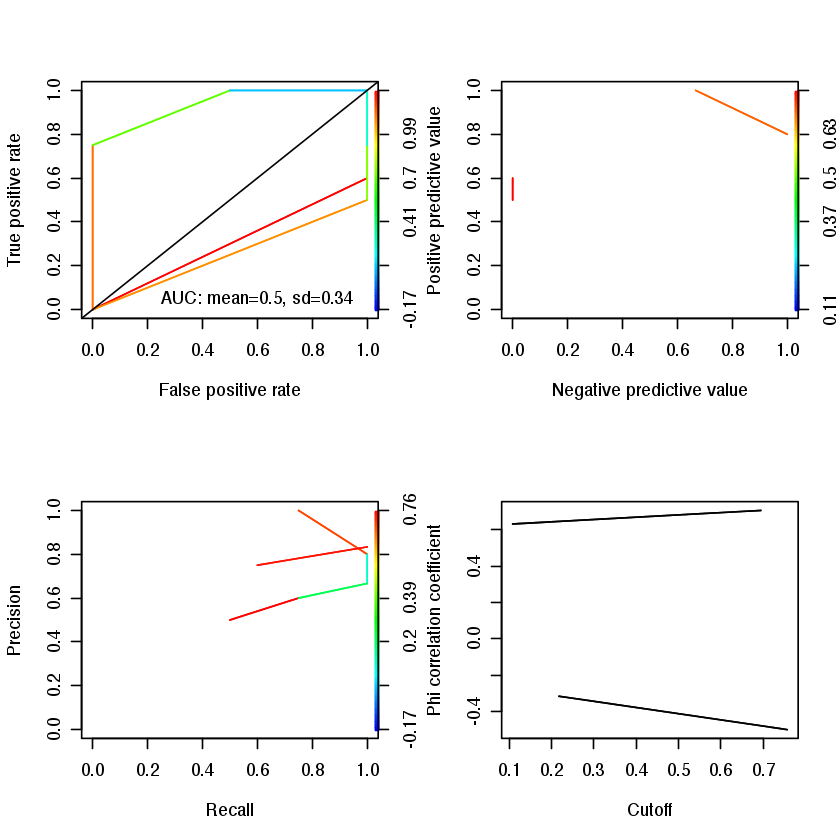

In [129]:
# without eats veggies
#div_vars = c(colnames(FrVg_color)[73:86])# ,'Q14_eats_Vegetables')
div_vars = c(colnames(FrVg_color)[78:86])# ,'Q14_eats_Vegetables')
div_vars
FrVg_color$dxCode = factor(FrVg_color$dxCode, levels = c('TD','ASD'))
table(FrVg_color$dxCode)

K=3; N=2; p=.1
mod=model_selection(df=FrVg_color,observations=div_vars,response='dxCode',family='binomial',model=glm,interactions=FALSE,test='LRT',thresh_screen=p,K=K,N=N,only_return_selected=FALSE)
vis=vis_logit(mod,intercept = FALSE)


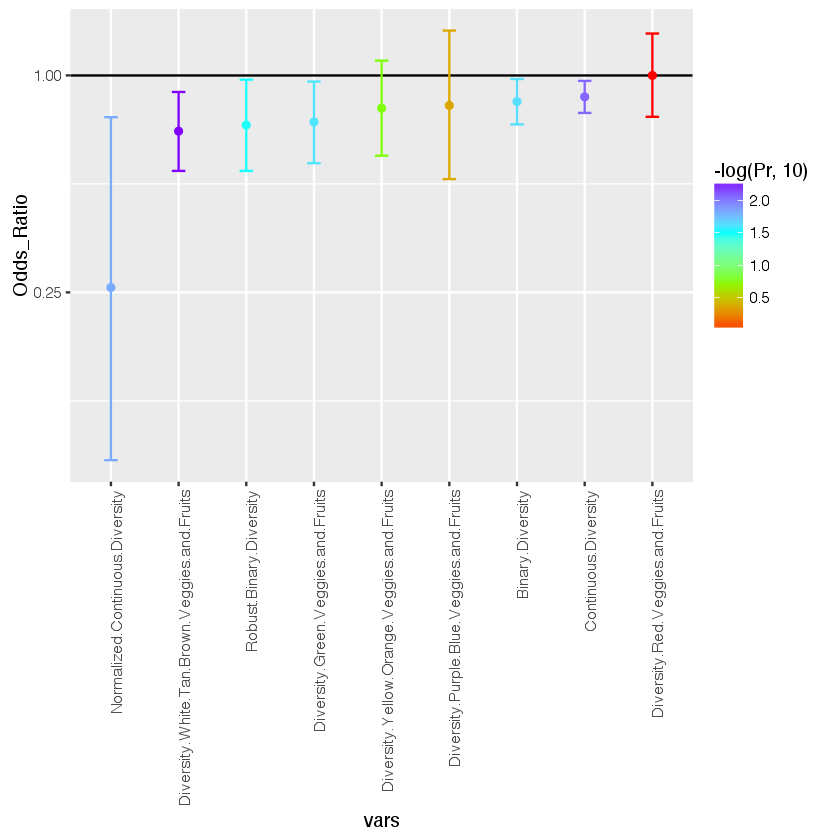

Estimate Std. Error   z value
(Intercept)                                   0.7403298  0.1309428  5.653839
Diversity.Green.Veggies.and.Fruits           -0.2290173  0.1355925 -1.689012
Diversity.White.Tan.Brown.Veggies.and.Fruits -0.3086021  0.1314811 -2.347121
                                                 Pr(>|z|)
(Intercept)                                  1.569028e-08
Diversity.Green.Veggies.and.Fruits           9.121713e-02
Diversity.White.Tan.Brown.Veggies.and.Fruits 1.891913e-02

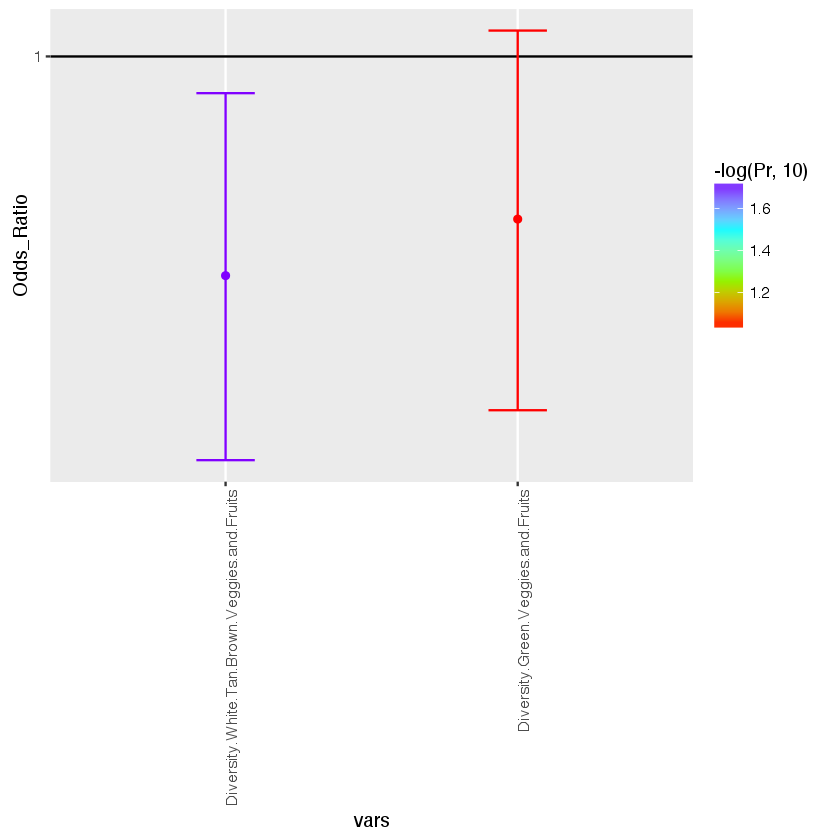

In [130]:
vis[[2]]
vis[[1]]
coef(summary(mod$final))

Figure X - Several measures of within and between color fruit and vegitable diversity. A univariate screening. B multivariate model.

Figure Xa shows that several measures of global fruit and veggitable diversity consumption appear protective. The most protective and highest significance global diversity effect is seem in "Normalized Continuous Diversity." This term ____ and is therefore arguably the best representative of color approximated nutritional diversity. We also note that consumption of White/Tan/Brown and Green fruites and vegitables appear significantly protective with moderate magnitude. 

The multivarite model discards the global diversity terms and selects only White/Tan/Brown and Green fruite and vegitable diversity; only White/Tan/Brown fruit and vegitable diversity appears significant in this final model. Considering the signiicance of these terms in the univariate models and the discarding of the global diversity term in the final model, it is possible that White/Tan/Brown and Green fruit and vegitable diversity are the primary contributors to the protective effect.

## Regression Model of Fruit and Vegetable Diversity, Eats-Vegitables Controlled

In [150]:
# mod=model_selection(df=FrVg_color,observations=div_vars,response='dxCode',family=binomial,model=glm,interactions='none',test='LRT',thresh_screen=.2,thresh_prune=.05,only_return_selected=FALSE,ploton=FALSE)
FrVg_color$dxCode = factor(FrVg_color$dxCode,levels = c('TD','ASD'))
#FrVg_color_tmp = na.omit( FrVg_color[,c('dxCode',div_vars,'CSBS_Total_1_perMo_factor','Q14_eats_Vegetables')] )
FrVg_color_tmp = na.omit( FrVg_color[,c('dxCode',div_vars,'Q14_eats_Vegetables')] )
FrVg_color_tmp$EatVeg_binary = factor( ifelse( FrVg_color_tmp$Q14_eats_Vegetables > 2 , ifelse(FrVg_color_tmp$Q14_eats_Vegetables > 4, 'High_veg', 'Med_veg') , 'Min_veg'))
#FrVg_color_tmp$EatVeg_binary = factor( ifelse( FrVg_color_tmp$Q14_eats_Vegetables > 0 ,'Yes_veg' , 'No_veg'))
print(table(FrVg_color$dxCode))

print(table(FrVg_color_tmp$dxCode,FrVg_color_tmp$EatVeg_binary))


 TD ASD 
186 293 
     
      High_veg Med_veg Min_veg
  TD       100      85       1
  ASD       75     172      46


Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...


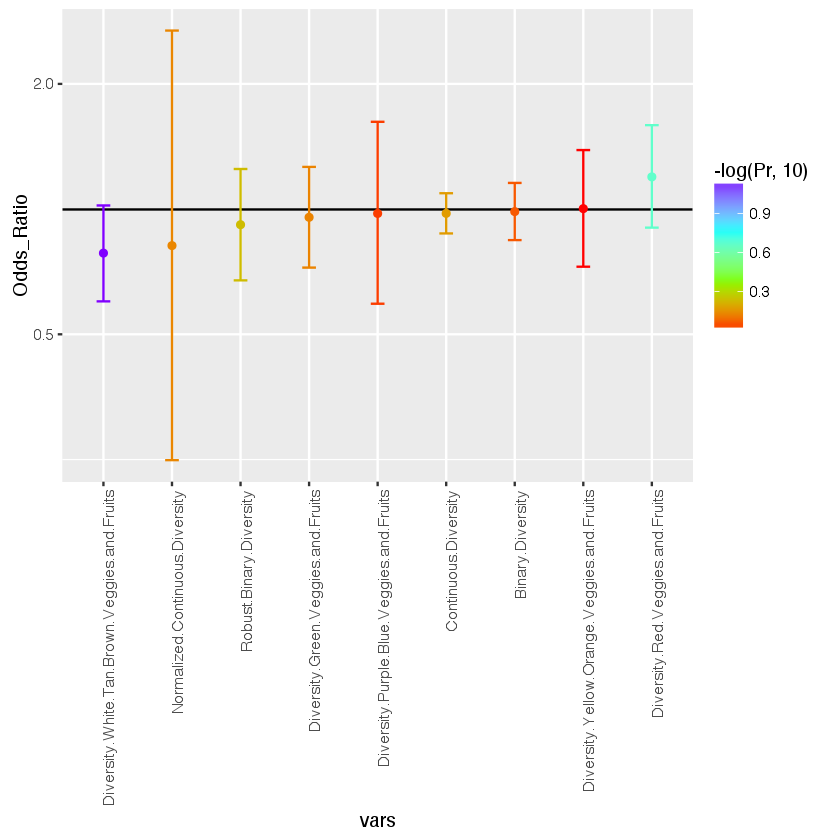

In [151]:
Pr1=c();Pr2=c(); mod1=list(); mod01=list();mod02=list();mod03=list(); mod2=list(); mod3=list(); Pr3=c()
for(i in div_vars){
    mod02[[i]]=glmer(dxCode ~ (1|EatVeg_binary) , data=FrVg_color_tmp , family=binomial)
    mod2[[i]]=glmer(as.formula(paste('dxCode ~',i,'+ (1|EatVeg_binary)')) , data=FrVg_color_tmp , family=binomial)
    Pr2[i]=anova(mod2[[i]],mod02[[i]],test='LRT')[2,8]
}
attr(mod2,'Pr') = Pr2
vis_out = vis_logit(out=list(screen=mod2,final=NULL))
vis_out$univar

Figure X - univariate glmer models controlling for binary consumption of vegitables.

We examine the vegitable consumption effect further and control for the binary consumption of vegitables. Since consumption of more vegitables will trivially correlate to the diversity of vegitables consumed, we use a mixed effect model to attempt to control for the number of vegitables an individual child consumes using seperate intercepts for childrent consuming vegitables rated: 0-1 (low), 2-4 (moderate), and 5 (high).

As expected, when controlling for correlated signal, the strength of these associations is diminished. We note that the White/Tan/Brown diversity retains marginal significance (Pr(z)~.1) despite this aggressive control. This is promissing further evidence that nutritional diversity and subsequenctly microbial diversity may be relevant to the onset of ASD.

#### issue: to make this claim we should also control for "eats fruit"

## Regression Model of Fruit and Nutrient Profile

[1] "Folate_excellent"  "Folate_very.good"  "folate_AMONGtop20"
[4] "beta_carotene"


 TD ASD 
186 293 

[1] "Folate_excellent"
[1] "Folate_very.good"
[1] "folate_AMONGtop20"
[1] "beta_carotene"
Start:  AIC=641.77
dxCode ~ Folate_excellent + Folate_very.good + folate_AMONGtop20 + 
    beta_carotene

                    Df Deviance    AIC
- Folate_very.good   1   631.77 639.77
- Folate_excellent   1   631.77 639.77
- folate_AMONGtop20  1   632.24 640.24
- beta_carotene      1   633.63 641.63
<none>                   631.77 641.77

Step:  AIC=639.77
dxCode ~ Folate_excellent + folate_AMONGtop20 + beta_carotene

                    Df Deviance    AIC
- Folate_excellent   1   631.77 637.77
- beta_carotene      1   633.67 639.67
<none>                   631.77 639.77
- folate_AMONGtop20  1   634.58 640.58

Step:  AIC=637.77
dxCode ~ folate_AMONGtop20 + beta_carotene

                    Df Deviance    AIC
- beta_carotene      1   633.72 637.72
<none>                   631.77 637.77
- folate_AMONGtop20  1   635.01 639.01

Step:  AIC=637.72
dxCode ~ folate_AMONGtop20

                    Df Devi

Warning message:
In min(which(col.cutoffs <= perf@alpha.values[[i]][j])): no non-missing arguments to min; returning InfWarning message:
In min(which(col.cutoffs <= perf@alpha.values[[i]][j])): no non-missing arguments to min; returning InfWarning message:
In min(which(col.cutoffs <= perf@alpha.values[[i]][j])): no non-missing arguments to min; returning InfWarning message:
In min(which(col.cutoffs <= perf@alpha.values[[i]][j])): no non-missing arguments to min; returning InfWarning message:
In min(which(col.cutoffs <= perf@alpha.values[[i]][j])): no non-missing arguments to min; returning InfWarning message:
In min(which(col.cutoffs <= perf@alpha.values[[i]][j])): no non-missing arguments to min; returning InfWaiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...


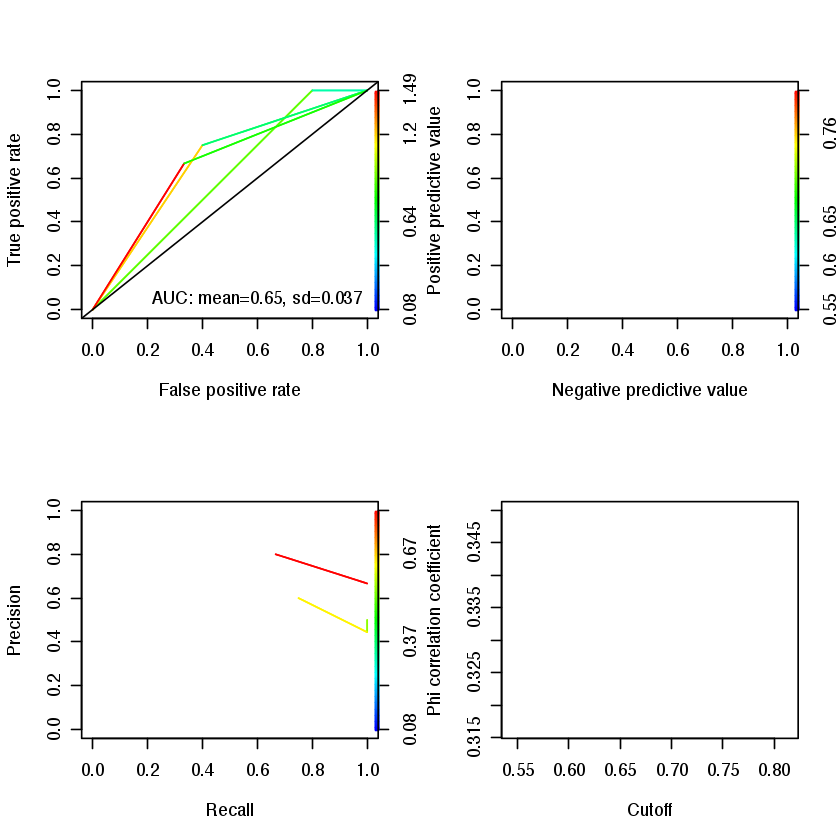

In [163]:
# without eats veggies
div_vars = c('Folate_excellent', 'Folate_very.good', 'folate_AMONGtop20' ,'beta_carotene')
#div_vars = c('Folate_excellent', 'Folate_very.good', 'folate_AMONGtop20', 'FOLATE_highestDRI_div_DV(>10%)' ,'FOLATE_highestDRI_div_DV(>20%)' ,'Beta-Carotene')
div_vars
FrVg_nutri$dxCode = factor(FrVg_nutri$dxCode, levels = c('TD','ASD'))
colnames(FrVg_nutri)[colnames(FrVg_nutri)=='Beta-Carotene'] = 'beta_carotene'
table(FrVg_nutri$dxCode)


K=3; N=2; p=.4
mod=model_selection(df=FrVg_nutri,observations=div_vars,response='dxCode',family='binomial',model=glm,interactions=FALSE,test='LRT',thresh_screen=p,K=K,N=N,only_return_selected=FALSE)
vis=vis_logit(mod,intercept = FALSE)


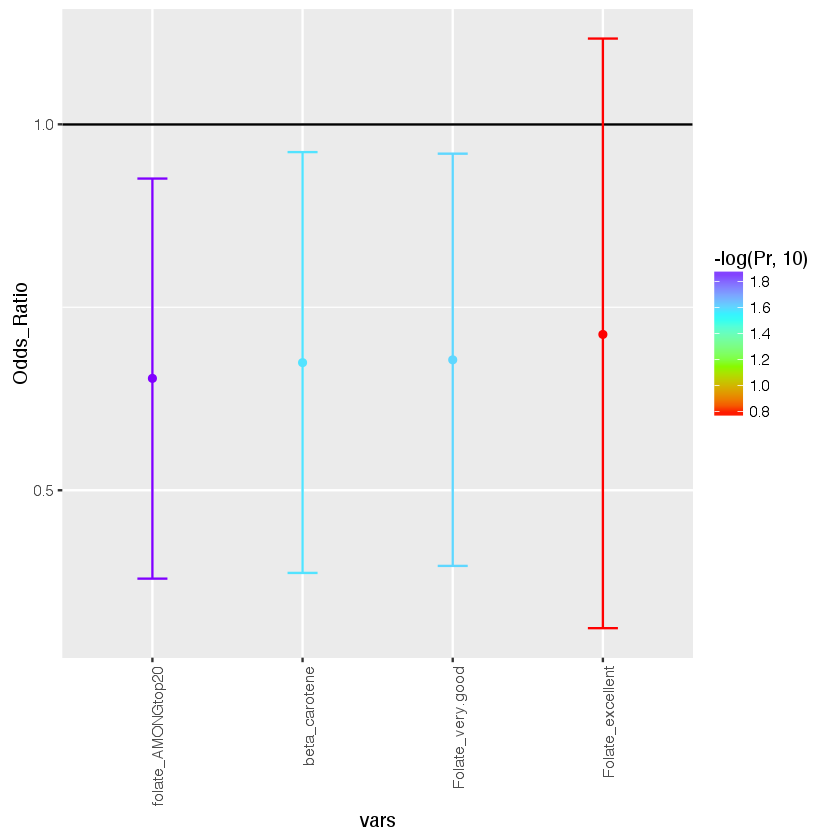

In [166]:
vis[[2]]


Figure X - GLM regression models showing the association of folate and beta-carotine with ASD onset

Probing further into the nutritional diversity - gut microbiome - ASD hypothesis we examined the association between gut microbiome revant nutrients (folate and beta-carotene [cite...]) and ASD onset. Both folate and beta-carotene showed significantly protective effects. This is consistent with the hypothesis that protection from ASD onset may be modulated by the microbiome and influenced by nutritional diversity of a diet.

## Regression Model of Fruit and Nutrient Profile, Eats-Vegitables Controlled

In [168]:
FrVg_nutri$dxCode = factor(FrVg_nutri$dxCode,levels = c('TD','ASD'))
FrVg_nutri_tmp = na.omit( FrVg_nutri[,c('dxCode',div_vars,'Q14_eats_Vegetables')] )
FrVg_nutri_tmp$EatVeg_binary = factor( ifelse( FrVg_nutri_tmp$Q14_eats_Vegetables > 2 , ifelse(FrVg_nutri_tmp$Q14_eats_Vegetables > 4, 'High_veg', 'Med_veg') , 'Min_veg'))
print(table(FrVg_nutri_tmp$dxCode))

print(table(FrVg_nutri_tmp$dxCode,FrVg_nutri_tmp$EatVeg_binary))


 TD ASD 
186 293 
     
      High_veg Med_veg Min_veg
  TD       100      77       9
  ASD       75     135      83


Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...
Computing profile confidence intervals ...


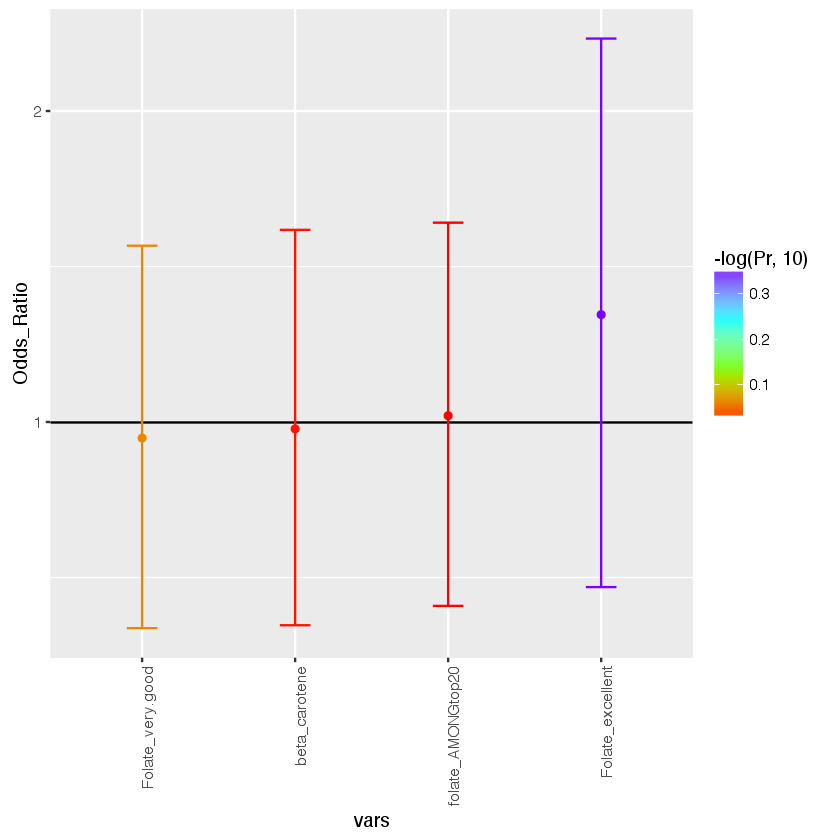

In [169]:
Pr1=c();Pr2=c(); mod1=list(); mod01=list();mod02=list();mod03=list(); mod2=list(); mod3=list(); Pr3=c()
for(i in div_vars){
    mod02[[i]]=glmer(dxCode ~ (1|EatVeg_binary) , data=FrVg_nutri_tmp , family=binomial)
    mod2[[i]]=glmer(as.formula(paste('dxCode ~',i,'+ (1|EatVeg_binary)')) , data=FrVg_nutri_tmp , family=binomial)
    Pr2[i]=anova(mod2[[i]],mod02[[i]],test='LRT')[2,8]
}
attr(mod2,'Pr') = Pr2
vis_out = vis_logit(out=list(screen=mod2,final=NULL))
vis_out$univar

# ahmad, I thought that one of these was significant after correction, what is going on here?
if we cant sort this out we may need to get rid of the nutrient section

# Discussion

We do not propose that eating a bouquet of fruits and vegitables will prevent Autism. But there appears to be a significant association between the onset of ASD and the diversity of fruit and vegitable consumption. It is possible that either a healthy microbiome helps protect against autism onset [cite nutrition ~ brain] or a disbiotic gut may result in worsening of autism phenotype [cite leaky gut, treatment of bad bacteria...]. Reguardless, the health or disbiosis of the gut microbiome can be modulated by diet and encouraged by nutritional diversity. By this mechanism, it is possible that nutritional diversity, observed here as "eats vegitables" may modulate ASD risk via the health of the gut microbiome.

#### self infliction
Due to the grey diet of ASD children [cite] they may actually worsen their behavioral and gastrointestinal symptoms by avoiding nutritional diverity and inducing or encouraging disbiosis.

# Trash

In [39]:
mod0=glm(as.factor(dxCode) ~ Q14_eats_Vegetables , data=FrVg_color , family=binomial)
obs = c('Green.Veggies.and.Fruits','Red.Veggies.and.Fruits','Yellow.Orange.Veggies.and.Fruits','White.Tan.Brown.Veggies.and.Fruits','Purple.Blue.Veggies.and.Fruits','Diversity.Green.Veggies.and.Fruits','Diversity.Red.Veggies.and.Fruits','Diversity.Yellow.Orange.Veggies.and.Fruits','Diversity.White.Tan.Brown.Veggies.and.Fruits','Diversity.Purple.Blue.Veggies.and.Fruits','Binary.Diversity','Robust.Binary.Diversity','Continuous.Diversity','Normalized.Continuous.Diversity')
for(i in obs){
    print(i)
    form = as.formula(paste('as.factor(dxCode) ~',i,'+ Q14_eats_Vegetables'))
    mod1=glm(form , data=FrVg_color , family=binomial)
    print(anova(mod1,mod0,test='LRT'))
}

[1] "Green.Veggies.and.Fruits"
Analysis of Deviance Table

Model 1: as.factor(dxCode) ~ Green.Veggies.and.Fruits + Q14_eats_Vegetables
Model 2: as.factor(dxCode) ~ Q14_eats_Vegetables
  Resid. Df Resid. Dev Df Deviance Pr(>Chi)
1       476     562.59                     
2       477     562.71 -1 -0.12196   0.7269
[1] "Red.Veggies.and.Fruits"
Analysis of Deviance Table

Model 1: as.factor(dxCode) ~ Red.Veggies.and.Fruits + Q14_eats_Vegetables
Model 2: as.factor(dxCode) ~ Q14_eats_Vegetables
  Resid. Df Resid. Dev Df Deviance Pr(>Chi)  
1       476     559.67                       
2       477     562.71 -1  -3.0358  0.08145 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "Yellow.Orange.Veggies.and.Fruits"
Analysis of Deviance Table

Model 1: as.factor(dxCode) ~ Yellow.Orange.Veggies.and.Fruits + Q14_eats_Vegetables
Model 2: as.factor(dxCode) ~ Q14_eats_Vegetables
  Resid. Df Resid. Dev Df Deviance Pr(>Chi)
1       476     562.58                     
2       477

In [ ]:
mod=glmer(as.factor(dxCode) ~ Normalized.Continuous.Diversity + (1|Q14_eats_Vegetables) , data=FrVg_color , family=binomial)
mods=summary(mod)

In [9]:
if(F){
    mod = list(screen=list())
    mod0=glm(dxCode ~ CSBS_Total_1_perMo , data=Feed , family=binomial)
    for(i in GIvars){
        mod$screen[[i]] = glm(as.formula(paste('dxCode ~',i,'+ CSBS_Total_1_perMo')) , data=Feed , family=binomial)
    }
    attr(mod$screen,'Pr') = unlist(lapply(mod$screen,function(mod1) anova(mod1,mod0,test='LRT')[2,5]))
    mod_vis = vis_logit(mod)
    mod_vis$univar
}

In [10]:
vis_lme <- function(screen){
screen_df = as.data.frame( cbind( do.call(rbind,lapply(screen,function(x) coef(summary(x))[2,] ) ) , 
    do.call(rbind,lapply(screen,function(x) exp(cbind(Odds_Ratio=coef(summary(x))[,1], confint(x)[-1,]))[2,] ) )
) )
#colnames(screen_df)[colnames(screen_df)=='Estimate'] = 'Odds_Ratio'
screen_df$vars = factor( rownames(screen_df) , levels = rownames(screen_df)[order(screen_df$Odds_Ratio)] )
    tmp=screen_df
colnames(screen_df)[c(4,6:7)] = c('Pr', 'X2.5','X97.5')
screen_df = screen_df[order(screen_df$Odds_Ratio),]
limits <- aes(ymax = X97.5, ymin=X2.5)
p <- ggplot(screen_df, aes(x=vars, y=Odds_Ratio,color=-log(Pr,10)))
p <- p + geom_point() + geom_errorbar(limits, width=0.2) + theme(axis.text.x = element_text(angle = 90, hjust = 1))
p <- p + scale_y_continuous(trans='log10') + scale_colour_gradientn(colours=rainbow(4))
return(p)
}


## Weighted GI Composit (wGIC) [SKIP?]
### Regression Model of GI Disorder Variables

In [30]:
groups = list(levels(Feed$age_group),levels(Feed$age_group)[2],levels(Feed$age_group)[3],levels(Feed$age_group)[1])
GIvars = GIvars[!GIvars%in%bad_vars]
#source('modeling_functions.COPY.7_13_16.r')

Feed$dxCode = factor(Feed$dxCode,levels=c('TD','ASD'))

vis_out_screen = list()
vis_out_final = list()
vis_out_cross = list()

for(g in groups){
    print(g)
    keep_g = Feed$age_group %in% g # SELECT
    Feed_tmp = Feed[keep_g,!colnames(Feed) %in% bad_vars]
    sink(file=(f<-file())) 
    mod=model_selection(df=Feed_tmp,observations=GIvars,response='dxCode',family=binomial,model=glm,interactions='none',test='LRT',thresh_screen=.3,thresh_prune=.05)
#    mod=model_selection(df=Feed_tmp,observations=c(GIvars,'AgeMo_Infant_feeding'),response='dxCode',family=binomial,model=glm,interactions='none',test='LRT',thresh_screen=.3,thresh_prune=.05)
    sink() ## undo silencing
    close(f)
    table(Feed$dxCode)
    vis=vis_logit(mod)
    vis_out_screen[[g]] = vis[[2]]
    vis_out_final[[g]] = vis[[1]]
    Feed_tmp = na.omit( Feed[keep_g,c(all.vars(mod$final$formula),'subjectid')] )
    resp = all.vars(mod$final$formula)[1]
    # cross validation
    out = cross_valid_kfold(data=Feed_tmp,formula=mod$final$formula,resp=resp,family=binomial,K=4,model=glm)
    # assessment
    pred_assess(resp=resp,pred=out$pred_out,truth=out$labels_out,xlim=c(0,1),ylim=c(0,1)) 
    # seperation
    Feed_tmp$GIcomposite_glm = predict(mod$final,newdata = Feed_tmp)
    #print(qplot(data=Feed_tmp,x=dxCode,y=GIcomposite_glm,geom = 'boxplot'))
    Feed_tmp$dxCode = factor(Feed_tmp$dxCode,levels=c('ASD','TD'))
    print(ggplot(data=Feed_tmp,aes(x=dxCode,y=GIcomposite_glm,color=dxCode)) + geom_boxplot(outlier.shape = NA) + geom_jitter())
    ## complete model
    #Feed_tmp = na.omit(Feed[keep_g,c('dxCode',GIvars)])
    #full_mod = glm(as.formula(paste('dxCode ~',paste(GIvars,collapse='+'))),data=Feed_tmp,family=binomial )
    #print(coef(summary(full_mod)))
    #Feed_tmp$GIcomposite_glm_complete = predict(full_mod,newdata = Feed_tmp)
    #print(qplot(data=Feed_tmp,x=dxCode,y=GIcomposite_glm_complete,geom = 'boxplot'))
    Feed = merge(Feed,Feed_tmp[,c('GIcomposite_glm','subjectid')],by='subjectid')

}

[1] "(10,24]"  "(24,36]"  "(36,100]"


Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...


ERROR: Error in `[[<-`(`*tmp*`, g, value = structure(list(data = structure(list(: no such index at level 1



In [ ]:
groups = list(all=levels(Feed$age_group),intermediate=levels(Feed$age_group)[2],post_finalDx=levels(Feed$age_group)[3],intake=levels(Feed$age_group)[1])
GIvars = GIvars[!GIvars%in%bad_vars]
#source('modeling_functions.COPY.7_13_16.r')

Feed$dxCode = factor(Feed$dxCode,levels=c('TD','ASD'))

vis_out_screen = list()
vis_out_final = list()
vis_out_cross = list()

for(gn in names(groups)){
    g = groups[[gn]]
    print(g)
    keep_g = Feed$age_group %in% g # SELECT
    Feed_tmp = Feed[keep_g,!colnames(Feed) %in% bad_vars]
    sink(file=(f<-file())) ; 
    mod=model_selection(df=Feed_tmp,observations=GIvars,response='dxCode',family=binomial,model=glm,interactions='none',test='LRT',thresh_screen=.3,thresh_prune=.05)
#    mod=model_selection(df=Feed_tmp,observations=c(GIvars,'AgeMo_Infant_feeding'),response='dxCode',family=binomial,model=glm,interactions='none',test='LRT',thresh_screen=.3,thresh_prune=.05)
    sink(); close(f) ## undo silencing
    table(Feed$dxCode)
    vis=vis_logit(mod)
    vis_out_screen[[gn]] = vis[[2]]; vis_out_final[[gn]] = vis[[1]]
    # cross validation
    out = cross_valid_kfold(data=Feed_tmp,formula=mod$final$formula,resp='dxCode',family=binomial,K=4,model=glm)
    # assessment
    vis_out_cross[[gn]] = pred_assess(resp='dxCode',pred=out$pred_out,truth=out$labels_out,xlim=c(0,1),ylim=c(0,1)) 
    # seperation
    Feed_tmp[[wgic_i<-paste0('GIcomposite_glm','_',gn)]] = predict(mod$final,newdata = Feed_tmp)
    Feed_tmp$dxCode = factor(Feed_tmp$dxCode,levels=c('ASD','TD'))
    print(ggplot(data=Feed_tmp,aes(x=dxCode,y=wgic_i,color=dxCode)) + geom_boxplot(outlier.shape = NA) + geom_jitter())

    Feed = merge(Feed,Feed_tmp[,c(wgic_i,'subjectid')],by='subjectid')

}

In [ ]:
keep = (!is.na(Feed$dxCode))&Feed$dxCode%in%c('ASD','TD')&Feed$AgeMo_Infant_feeding>0&(!Feed$subjectid%in%bad_subj)

tmp = droplevels( Feed[keep,c('AgeMo_Infant_feeding','dxCode','GIcomposite_glm','age_group')] )

tmp$dxCode = factor(tmp$dxCode,levels=c('TD','ASD')[2:1])

#thresh1 = 20
#thresh2 = 40
    
g_box = ggplot(data=droplevels(na.omit(tmp)),aes(y=GIcomposite_glm,x=age_group,fill=dxCode))+  
 geom_boxplot()# + geom_jitter(size=.1)

g_glm = ggplot(data=na.omit(tmp[tmp$AgeMo_Infant_feeding<100,]),aes(y=GIcomposite_glm,x=AgeMo_Infant_feeding,color=dxCode))+ 
    geom_point() + geom_smooth(aes(group=dxCode),method='glm')
    
g_loe = ggplot(data=na.omit(tmp[tmp$AgeMo_Infant_feeding<100,]),aes(y=GIcomposite_glm,x=log(AgeMo_Infant_feeding),color=dxCode))+ 
    geom_point() + geom_smooth(aes(group=dxCode),method='loess') 

g_glm_young = ggplot(data=na.omit(tmp[tmp$AgeMo_Infant_feeding<=thresh1,]),aes(y=GIcomposite_glm,x=AgeMo_Infant_feeding,color=dxCode))+ 
    geom_point() + geom_smooth(aes(group=dxCode),method='glm')
    
g_loe_young = ggplot(data=na.omit(tmp[tmp$AgeMo_Infant_feeding<=thresh1,]),aes(y=GIcomposite_glm,x=AgeMo_Infant_feeding,color=dxCode))+ 
    geom_point() + geom_smooth(aes(group=dxCode),method='loess')

g_glm_old = ggplot(data=na.omit(tmp[tmp$AgeMo_Infant_feeding>thresh2,]),aes(y=GIcomposite_glm,x=AgeMo_Infant_feeding,color=dxCode))+ 
    geom_point() + geom_smooth(aes(group=dxCode),method='glm')
    
g_loe_old = ggplot(data=na.omit(tmp[tmp$AgeMo_Infant_feeding>thresh2,]),aes(y=GIcomposite_glm,x=AgeMo_Infant_feeding,color=dxCode))+ 
    geom_point() + geom_smooth(aes(group=dxCode),method='loess')

g_glm_mid = ggplot(data=na.omit(tmp[tmp$AgeMo_Infant_feeding<=thresh2&tmp$AgeMo_Infant_feeding>thresh1,]),aes(y=GIcomposite_glm,x=AgeMo_Infant_feeding,color=dxCode))+ 
    geom_point() + geom_smooth(aes(group=dxCode),method='glm')
    
g_loe_mid = ggplot(data=na.omit(tmp[tmp$AgeMo_Infant_feeding<=thresh2&tmp$AgeMo_Infant_feeding>thresh1,]),aes(y=GIcomposite_glm,x=AgeMo_Infant_feeding,color=dxCode))+ 
    geom_point() + geom_smooth(aes(group=dxCode),method='loess')

#grid.arrange(g_box, g_loe, ncol = 1)
#grid.arrange(g_box, g_glm, g_loe, ncol = 1)

#grid.arrange(g_box, g_glm, g_loe, g_glm_young, g_glm_mid,g_glm_old, g_loe_young, g_loe_mid,g_loe_old, ncol = 3, 
g=grid.arrange(g_box, g_loe, g_glm_young, g_glm_mid,g_glm_old, ncol = 3, 
             layout_matrix = rbind( c(1,1,1), 
                                    c(2,2,2),
                                    c(3,4,5) ))
ggsave(plot=g,filename = 'wGIC_by_age.eps',height=10,width=10)


In [ ]:
tmp$dxCode = factor(tmp$dxCode,levels=c('TD','ASD'))

for(i in levels(tmp$age_group)){
    print(i)
    
    # basic anova
    print(summary( aov(GIcomposite_glm ~ dxCode , data=tmp[tmp$age_group==i,] ) ))

    # addative and interaction models
    mod1=glm( GIcomposite_glm~ dxCode+AgeMo_Infant_feeding , data=tmp[tmp$age_group==i,] ) 
    mod2=glm( GIcomposite_glm~ dxCode*AgeMo_Infant_feeding , data=tmp[tmp$age_group==i,] ) 
    
    print(summary(mod1))
    print(summary(mod2))
    print(anova(mod1,mod2,test='LRT'))
    
    print('----------------------------')
}

tmp$dxCode = factor(tmp$dxCode,levels=c('ASD','TD'))

## Regression Model of GI Disorder Variables, CSBS Controlled [SKIP?]

In [ ]:
table(Feed_tmp$dxCode)
table(Feed$dxCode)

In [ ]:
mod1=list() ; mod0=list() ; Pr = c() ; tmp_dat=list()
Feed_tmp = na.omit( Feed[,c('dxCode',GIvars,'CSBS_Total_1_perMo_factor')] )
for(i in GIvars){
    #tmp_dat[[i]] = na.omit( Feed[,c('dxCode',i,'CSBS_Total_1_perMo_factor')] )
    mod0[[i]]=glmer(dxCode ~ (1|CSBS_Total_1_perMo_factor) , data=Feed_tmp , family=binomial)
    mod1[[i]]=glmer(as.formula(paste('dxCode ~',i,'+ (1|CSBS_Total_1_perMo_factor)')) , data=Feed_tmp , family=binomial)
    Pr[i]=anova(mod1[[i]],mod0[[i]],test='LRT')[2,8]
}
attr(mod1,'Pr') = Pr
lapply(mod1,summary)
vis_lme(mod1)

In [ ]:
dontrun
#mod1=list() ; mod0=list() ; Pr = c() ; tmp_dat=list()
GIvars_screen = GIvars[Pr<.2]
Feed_tmp = na.omit( Feed[,c('dxCode',GIvars_screen,'CSBS_Total_1_perMo_factor')] )
#mod0=glmer(dxCode ~ (1|CSBS_Total_1_perMo_factor) , data=Feed_tmp , family=binomial)
mod1=glmer(as.formula(paste('dxCode ~',paste(GIvars_screen,collapse='+'),'+ (1|CSBS_Total_1_perMo_factor)')) , data=Feed_tmp , family=binomial)
#Pr=anova(mod1[[i]],mod0[[i]],test='LRT')[2,8]

#attr(mod1,'Pr') = Pr

vis_lme(mod1)

In [13]:
Feed_tmp = na.omit( Feed[,c('dxCode',GIvars,'CSBS_Total_1_perMo_factor')] )
formula = as.formula(paste('dxCode ~',paste(GIvars[Pr<.07],collapse='+'),'+ (1|CSBS_Total_1_perMo_factor)'))
mod1=glmer(formula , data=Feed_tmp , family=binomial)
summary(mod1)
#vis_lme(mod1,full=TRUE)
resp = 'dxCode'
# cross validation
out = cross_valid_kfold(data=Feed_tmp,formula=formula,resp=resp,family=binomial,K=3,model=glmer)
# assessment
pred_assess(resp=resp,pred=out$pred_out,truth=out$labels_out)  

ERROR: Error in paste(GIvars[Pr < 0.07], collapse = "+"): object 'Pr' not found


## OLD REGRESSION MODEL OF FEED VARIABLES

[1] "Q01.NewFoods"
[1] "Q02.EnjoysEating"
[1] "Q03.PoorAppetite"
[1] "Q04.EatsTooMuch"
[1] "Q05.EatsTooLittle"
[1] "Q06.FeedCry"
[1] "Q07.MealTantrum"
[1] "Q08.MealGT20Min"
[1] "Q09.FoodSitMouth"
[1] "Q10.FoodSpit"
[1] "Q11.MealRefuse"
[1] "Q12.EatsSoftOnly"
[1] "Q13.EatsVeg"
[1] "Q14.EatsMeatFish"
[1] "Q15.EatsStarches"
[1] "Q16.EatsFruits"
[1] "Q17.EatsSnacks"
[1] "Q18.EatsCereals"
[1] "Q19.DrinksMilk"
[1] "Q20.PreferDrink"
[1] "Q22.Vomits"
[1] "Q23.Chokes"
[1] "Q24.Chewing"
[1] "Q25.NGFeed"
[1] "Q27.Constip"
[1] "Q28.Diarrhea"
[1] "Q29.Gas"
[1] "Q30.Bloat"
[1] "Q31.AbdomPain"
[1] "Q32.Blech"
[1] "Q33.StoolImpact"
[1] "Q34.Reflux"
[1] "Q34a.RflxDiag"
[1] "Q34b.RflxDocVisits"
[1] "Q36.FeedCount"
[1] "Q37a.BreastBeginMo"
[1] "Q37b.BreastEndMo"
[1] "Q38.FoodAllergies"
[1] "AgeMo_Infant_feeding"
   [,1]                   [,2]                  [,3]               
   "Q01.NewFoods"         "Q02.EnjoysEating"    "Q03.PoorAppetite" 
Pr "1.34797137548549e-15" "0.00343008674591864" "0.31829797

Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be 

[1] "Q01.NewFoods"
[1] "Q02.EnjoysEating"
[1] "Q03.PoorAppetite"
[1] "Q04.EatsTooMuch"
[1] "Q05.EatsTooLittle"
[1] "Q06.FeedCry"
[1] "Q07.MealTantrum"
[1] "Q08.MealGT20Min"
[1] "Q09.FoodSitMouth"
[1] "Q10.FoodSpit"
[1] "Q11.MealRefuse"
[1] "Q12.EatsSoftOnly"
[1] "Q13.EatsVeg"
[1] "Q14.EatsMeatFish"
[1] "Q15.EatsStarches"
[1] "Q16.EatsFruits"
[1] "Q17.EatsSnacks"
[1] "Q18.EatsCereals"
[1] "Q19.DrinksMilk"
[1] "Q20.PreferDrink"
[1] "Q22.Vomits"
[1] "Q23.Chokes"
[1] "Q24.Chewing"
[1] "Q25.NGFeed"
[1] "Q27.Constip"
[1] "Q28.Diarrhea"
[1] "Q29.Gas"
[1] "Q30.Bloat"
[1] "Q31.AbdomPain"
[1] "Q32.Blech"
[1] "Q33.StoolImpact"
[1] "Q34.Reflux"
[1] "Q34a.RflxDiag"
[1] "Q34b.RflxDocVisits"
[1] "Q36.FeedCount"
[1] "Q37a.BreastBeginMo"
[1] "Q37b.BreastEndMo"
[1] "Q38.FoodAllergies"
[1] "AgeMo_Infant_feeding"
   [,1]                   [,2]                [,3]               
   "Q01.NewFoods"         "Q02.EnjoysEating"  "Q03.PoorAppetite" 
Pr "0.000189176911337706" "0.343294182474582" "0.14625426531139

Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be 

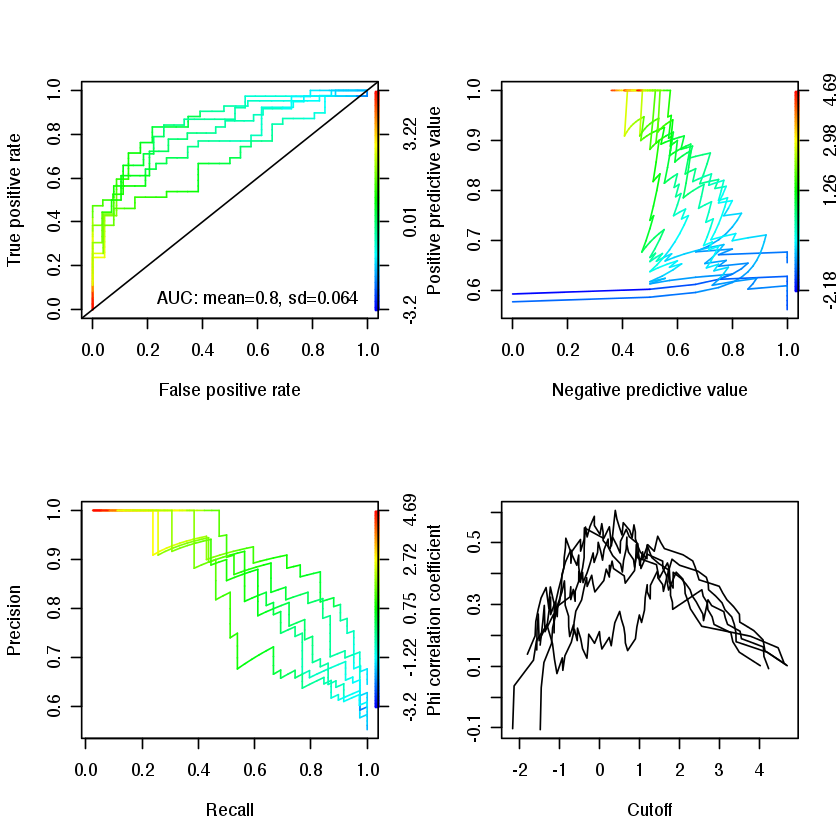

[1] "Q01.NewFoods"
[1] "Q02.EnjoysEating"
[1] "Q03.PoorAppetite"
[1] "Q04.EatsTooMuch"
[1] "Q05.EatsTooLittle"
[1] "Q06.FeedCry"
[1] "Q07.MealTantrum"
[1] "Q08.MealGT20Min"
[1] "Q09.FoodSitMouth"
[1] "Q10.FoodSpit"
[1] "Q11.MealRefuse"
[1] "Q12.EatsSoftOnly"
[1] "Q13.EatsVeg"
[1] "Q14.EatsMeatFish"
[1] "Q15.EatsStarches"
[1] "Q16.EatsFruits"
[1] "Q17.EatsSnacks"
[1] "Q18.EatsCereals"
[1] "Q19.DrinksMilk"
[1] "Q20.PreferDrink"
[1] "Q22.Vomits"
[1] "Q23.Chokes"
[1] "Q24.Chewing"
[1] "Q25.NGFeed"
[1] "Q27.Constip"
[1] "Q28.Diarrhea"
[1] "Q29.Gas"
[1] "Q30.Bloat"
[1] "Q31.AbdomPain"
[1] "Q32.Blech"
[1] "Q33.StoolImpact"
[1] "Q34.Reflux"


Warning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurred

[1] "Q34a.RflxDiag"
[1] "Q34b.RflxDocVisits"


Warning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurred

[1] "Q36.FeedCount"
[1] "Q37a.BreastBeginMo"
[1] "Q37b.BreastEndMo"
[1] "Q38.FoodAllergies"
[1] "AgeMo_Infant_feeding"
   [,1]                [,2]                [,3]               
   "Q01.NewFoods"      "Q02.EnjoysEating"  "Q03.PoorAppetite" 
Pr "0.345976425803938" "0.485106368344288" "0.790322049064038"
   [,4]                [,5]                [,6]               
   "Q04.EatsTooMuch"   "Q05.EatsTooLittle" "Q06.FeedCry"      
Pr "0.193325546224047" "0.839323448557868" "0.907255387291061"
   [,7]                [,8]                [,9]               
   "Q07.MealTantrum"   "Q08.MealGT20Min"   "Q09.FoodSitMouth" 
Pr "0.540631928412077" "0.784504906308404" "0.761132250175201"
   [,10]               [,11]               [,12]              
   "Q10.FoodSpit"      "Q11.MealRefuse"    "Q12.EatsSoftOnly" 
Pr "0.967946193530873" "0.368209620766046" "0.148578147161592"
   [,13]                 [,14]               [,15]              
   "Q13.EatsVeg"         "Q14.EatsMeatFish"  "Q15.EatsStarch

Warning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurred

                   Df   Deviance AIC
- Q15.EatsStarches  1 2.4034e-10  12
- Q16.EatsFruits    1 3.5762e-10  12
- Q13.EatsVeg       1 5.0913e-10  12
- Q04.EatsTooMuch   1 5.4018e-10  12
- Q18.EatsCereals   1 5.4036e-10  12
- Q12.EatsSoftOnly  1 5.7321e-10  12
<none>                3.0007e-10  14


Warning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurred


Step:  AIC=12
dxCode ~ Q04.EatsTooMuch + Q12.EatsSoftOnly + Q13.EatsVeg + Q16.EatsFruits + 
    Q18.EatsCereals



Warning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurred

                     Df   Deviance AIC
- Q12.EatsSoftOnly    1 2.4479e-10  10
- Q16.EatsFruits      1 2.5058e-10  10
- Q13.EatsVeg         1 2.6667e-10  10
- Q04.EatsTooMuch     1 3.8211e-10  10
- Q18.EatsCereals     1 5.6134e-10  10
<none>                  2.4034e-10  12
+ Q15.EatsStarches    1 3.0007e-10  14
+ Q23.Chokes          1 3.0007e-10  14
+ Q34b.RflxDocVisits  1 3.0007e-10  14


Warning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurred


Step:  AIC=10
dxCode ~ Q04.EatsTooMuch + Q13.EatsVeg + Q16.EatsFruits + Q18.EatsCereals



Warning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurred

                     Df Deviance    AIC
- Q16.EatsFruits      1   0.0000  8.000
- Q13.EatsVeg         1   0.0000  8.000
- Q04.EatsTooMuch     1   0.0000  8.000
<none>                    0.0000 10.000
- Q18.EatsCereals     1   2.7726 10.773
+ Q12.EatsSoftOnly    1   0.0000 12.000
+ Q34b.RflxDocVisits  1   0.0000 12.000
+ Q23.Chokes          1   0.0000 12.000
+ Q15.EatsStarches    1   0.0000 12.000


Warning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurred


Step:  AIC=8
dxCode ~ Q04.EatsTooMuch + Q13.EatsVeg + Q18.EatsCereals



Warning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurred

                     Df Deviance     AIC
- Q13.EatsVeg         1   0.0000  6.0000
- Q04.EatsTooMuch     1   0.0000  6.0000
<none>                    0.0000  8.0000
- Q18.EatsCereals     1   2.7726  8.7726
+ Q16.EatsFruits      1   0.0000 10.0000
+ Q12.EatsSoftOnly    1   0.0000 10.0000
+ Q34b.RflxDocVisits  1   0.0000 10.0000
+ Q23.Chokes          1   0.0000 10.0000
+ Q15.EatsStarches    1   0.0000 10.0000


Warning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurred


Step:  AIC=6
dxCode ~ Q04.EatsTooMuch + Q18.EatsCereals



Warning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurred

                     Df Deviance    AIC
<none>                    0.0000 6.0000
- Q04.EatsTooMuch     1   2.7726 6.7726
- Q18.EatsCereals     1   3.8191 7.8191
+ Q23.Chokes          1   0.0000 8.0000
+ Q13.EatsVeg         1   0.0000 8.0000
+ Q12.EatsSoftOnly    1   0.0000 8.0000
+ Q16.EatsFruits      1   0.0000 8.0000
+ Q15.EatsStarches    1   0.0000 8.0000
+ Q34b.RflxDocVisits  1   0.0000 8.0000


Waiting for profiling to be done...
Warning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWaiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to

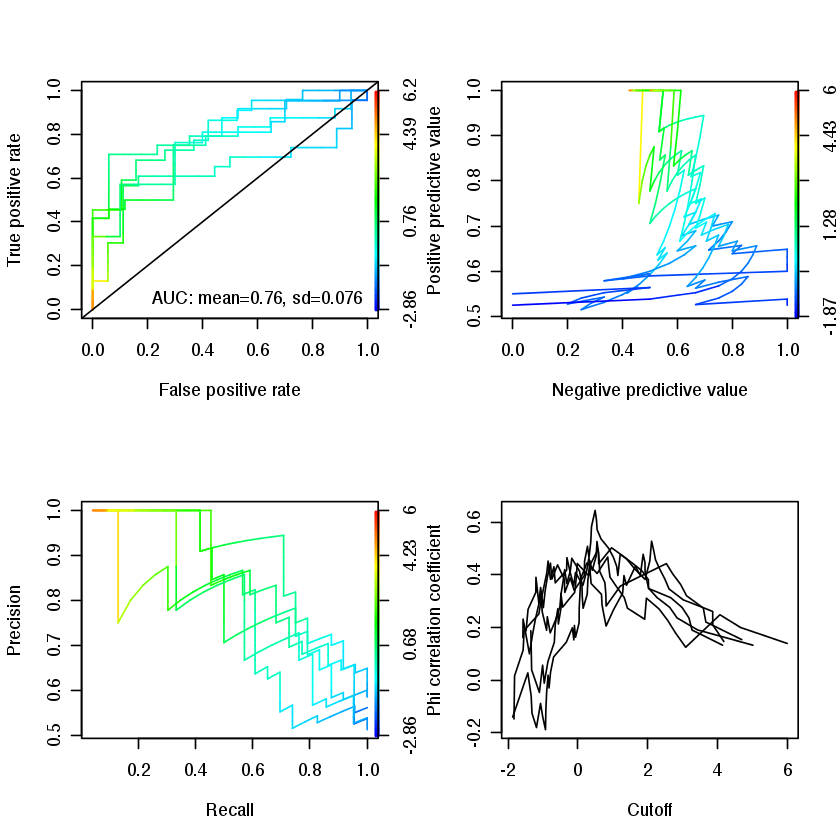

[1] "Q01.NewFoods"
[1] "Q02.EnjoysEating"
[1] "Q03.PoorAppetite"
[1] "Q04.EatsTooMuch"
[1] "Q05.EatsTooLittle"
[1] "Q06.FeedCry"
[1] "Q07.MealTantrum"
[1] "Q08.MealGT20Min"
[1] "Q09.FoodSitMouth"
[1] "Q10.FoodSpit"
[1] "Q11.MealRefuse"
[1] "Q12.EatsSoftOnly"
[1] "Q13.EatsVeg"
[1] "Q14.EatsMeatFish"
[1] "Q15.EatsStarches"
[1] "Q16.EatsFruits"
[1] "Q17.EatsSnacks"
[1] "Q18.EatsCereals"
[1] "Q19.DrinksMilk"
[1] "Q20.PreferDrink"
[1] "Q22.Vomits"
[1] "Q23.Chokes"
[1] "Q24.Chewing"
[1] "Q25.NGFeed"
[1] "Q27.Constip"
[1] "Q28.Diarrhea"
[1] "Q29.Gas"
[1] "Q30.Bloat"
[1] "Q31.AbdomPain"
[1] "Q32.Blech"
[1] "Q33.StoolImpact"
[1] "Q34.Reflux"
[1] "Q34a.RflxDiag"
[1] "Q34b.RflxDocVisits"


Warning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurred

[1] "Q36.FeedCount"
[1] "Q37a.BreastBeginMo"
[1] "Q37b.BreastEndMo"
[1] "Q38.FoodAllergies"
[1] "AgeMo_Infant_feeding"
   [,1]                   [,2]                 [,3]                
   "Q01.NewFoods"         "Q02.EnjoysEating"   "Q03.PoorAppetite"  
Pr "1.44987713561135e-06" "0.0850452401859541" "0.0473567300940095"
   [,4]                 [,5]                [,6]                
   "Q04.EatsTooMuch"    "Q05.EatsTooLittle" "Q06.FeedCry"       
Pr "0.0751756985857894" "0.328751644345022" "0.0247006094091811"
   [,7]                  [,8]                [,9]                
   "Q07.MealTantrum"     "Q08.MealGT20Min"   "Q09.FoodSitMouth"  
Pr "0.00059967404578678" "0.825821020107961" "0.0705075966475549"
   [,10]              [,11]               [,12]                
   "Q10.FoodSpit"     "Q11.MealRefuse"    "Q12.EatsSoftOnly"   
Pr "0.27502634770063" "0.453132667086273" "0.00807687791090618"
   [,13]                  [,14]                 [,15]                
   "Q13.EatsVeg"      

Waiting for profiling to be done...


ERROR: Error in cbind(exp(cbind(Odds_Ratio = coef(mod1), confint(mod1))), coef(summary(mod1))): number of rows of matrices must match (see arg 2)


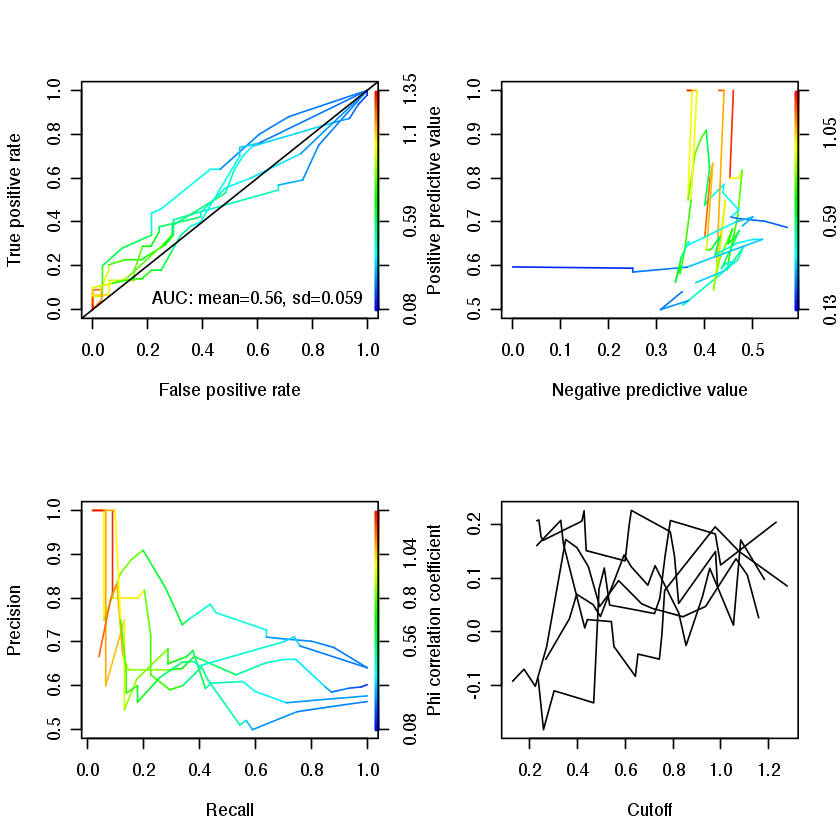

In [57]:
####
OLD REGRESSION MODEL OF FEED VARIABLES

##################
# all
Feed_tmp = Feed
mod=model_selection(df=Feed_tmp,observations=FeedVars,response='dxCode',family=binomial,model=glm,interactions='none',test='LRT',thresh_screen=.2,thresh_prune=.05,only_return_selected=FALSE,ploton=FALSE)
vis=vis_logit(mod)
vis_screen$all = vis[[2]]
vis_final$all = vis[[1]]

Feed_tmp = na.omit( Feed[,all.vars(mod$final$formula)] )
resp = all.vars(mod$final$formula)[1]
# cross validation
out = cross_valid_kfold(data=Feed_tmp,formula=mod$final$formula,resp=resp,family=binomial,K=5,model=glm)
# assessment
vis_perf$all = pred_assess(resp=resp,pred=out$pred_out,truth=out$labels_out) 

##################
# intake
Feed_tmp = Feed[ as.numeric(Feed$age_group)==1, ]
mod=model_selection(df=Feed_tmp,observations=FeedVars,response='dxCode',family=binomial,model=glm,interactions='none',test='LRT',thresh_screen=.2,thresh_prune=.05,only_return_selected=FALSE,ploton=FALSE)
vis=vis_logit(mod)
vis_screen$intake = vis[[2]]
vis_final$intake = vis[[1]]

Feed_tmp = na.omit( Feed[,all.vars(mod$final$formula)] )
resp = all.vars(mod$final$formula)[1]
# cross validation
out = cross_valid_kfold(data=Feed_tmp,formula=mod$final$formula,resp=resp,family=binomial,K=5,model=glm)
# assessment
vis_perf$intake = pred_assess(resp=resp,pred=out$pred_out,truth=out$labels_out) 
##################
# intermediate
Feed_tmp = Feed[ as.numeric(Feed$age_group)==2, ]
mod=model_selection(df=Feed_tmp,observations=FeedVars,response='dxCode',family=binomial,model=glm,interactions='none',test='LRT',thresh_screen=.2,thresh_prune=.05,only_return_selected=FALSE,ploton=FALSE)
vis=vis_logit(mod)
vis_screen$intermediate = vis[[2]]
vis_final$intermediate = vis[[1]]

Feed_tmp = na.omit( Feed[,all.vars(mod$final$formula)] )
resp = all.vars(mod$final$formula)[1]
# cross validation
out = cross_valid_kfold(data=Feed_tmp,formula=mod$final$formula,resp=resp,family=binomial,K=5,model=glm)
# assessment
vis_perf$intermediate = pred_assess(resp=resp,pred=out$pred_out,truth=out$labels_out) 
##################
# post_finalDx
Feed_tmp = Feed[ as.numeric(Feed$age_group)==3, ]
mod=model_selection(df=Feed_tmp,observations=FeedVars,response='dxCode',family=binomial,model=glm,interactions='none',test='LRT',thresh_screen=.2,thresh_prune=.05,only_return_selected=FALSE,ploton=FALSE)
vis=vis_logit(mod)
vis_screen$post_finalDx = vis[[2]]
vis_final$post_finalDx = vis[[1]]

Feed_tmp = na.omit( Feed[,all.vars(mod$final$formula)] )
resp = all.vars(mod$final$formula)[1]
# cross validation
out = cross_valid_kfold(data=Feed_tmp,formula=mod$final$formula,resp=resp,family=binomial,K=2,model=glm)
# assessment
vis_perf$post_finalDx = pred_assess(resp=resp,pred=out$pred_out,truth=out$labels_out) 

## moved from veggi diversity effect

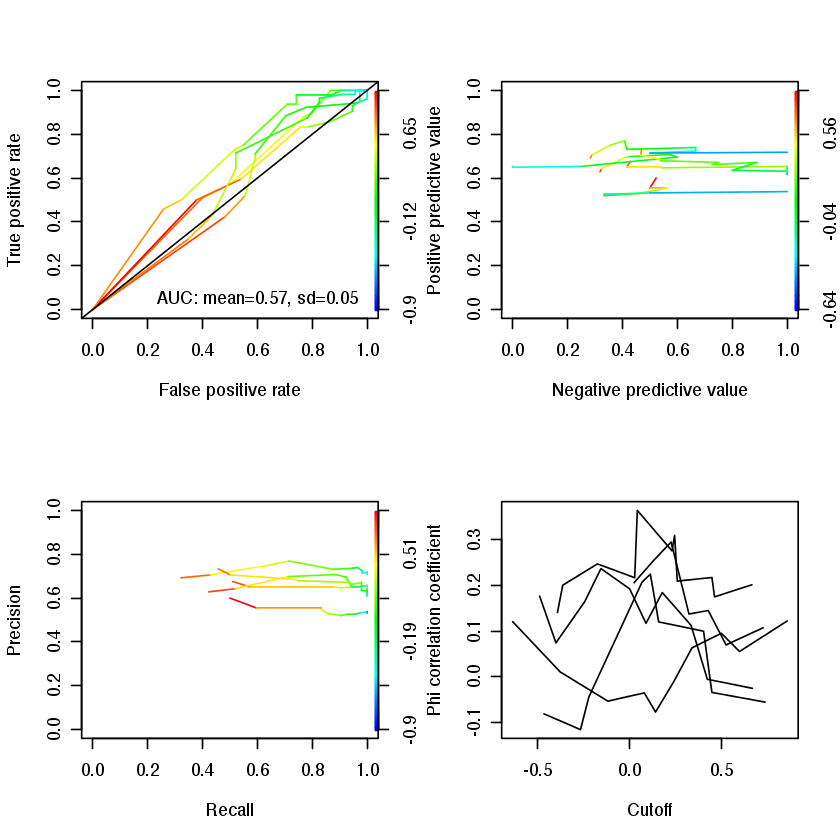

In [377]:
form = mod$final$formula
FrVg_color_tmp = na.omit( FrVg_color[,all.vars(form)] )
resp = all.vars(form)[1]
# cross validation
out = cross_valid_kfold(data=FrVg_color_tmp,formula=form,resp=resp,family=binomial,K=5,model=glm)
# assessment
pred_assess(resp=resp,pred=out$pred_out,truth=out$labels_out,xlim=c(0,1),ylim=c(0,1)) 

In [410]:
# with eats veggies & INTERACTIONS
FrVg_color$EatVeg_binary = factor( ifelse( FrVg_color$Q14_eats_Vegetables > 0,'Yes_veg' , 'No_veg'))
div_vars = c(colnames(FrVg_color)[78:86]  ,'EatVeg_binary')
FrVg_color$dxCode = factor(FrVg_color$dxCode, levels = c('TD','ASD'))
mod=model_selection(df=FrVg_color,observations=div_vars,response='dxCode',family=binomial,model=glm,interactions='none',test='LRT',thresh_screen=.2,thresh_prune=.05,only_return_selected=FALSE,ploton=FALSE)

df = FrVg_color
#select = c(names(observationsL)[attr(observationsL,'Pr')<.05])
#select = all.vars(mod$final$formula[-1])
select = unique(c(all.vars(mod$final$formula[-1]) , sort(names(observationsL)[order(attr(observationsL,'Pr'))])[1:3]))
print(select)

	f_m<-mod$final$formula
	f_i<-as.formula(paste('dxCode ~ ',paste(select,collapse='*'),sep=''))
#	f_i<-as.formula(paste('dxCode',' ~ ',paste(select,collapse='*'),sep=''))
#	dbg <<- list(df,observations,response,f)
	df_tmp <- na.omit(df[,c(select,'dxCode')])
	mod_i <- model(f_i,family=binomial,data=df_tmp )
#	step <- step(mod, direction="both")
	step <- stepAIC(mod_i, direction="backward",scope=list(f_m,f_i))

[1] "Diversity.Green.Veggies.and.Fruits"
[1] "Diversity.Red.Veggies.and.Fruits"
[1] "Diversity.Yellow.Orange.Veggies.and.Fruits"
[1] "Diversity.White.Tan.Brown.Veggies.and.Fruits"
[1] "Diversity.Purple.Blue.Veggies.and.Fruits"
[1] "Binary.Diversity"
[1] "Robust.Binary.Diversity"
[1] "Continuous.Diversity"
[1] "Normalized.Continuous.Diversity"
[1] "EatVeg_binary"
   [,1]                                 [,2]                              
   "Diversity.Green.Veggies.and.Fruits" "Diversity.Red.Veggies.and.Fruits"
Pr "0.0238320101650379"                 "0.998646836829638"               
   [,3]                                        
   "Diversity.Yellow.Orange.Veggies.and.Fruits"
Pr "0.175808402674754"                         
   [,4]                                          
   "Diversity.White.Tan.Brown.Veggies.and.Fruits"
Pr "0.00525896229640409"                         
   [,5]                                       [,6]                
   "Diversity.Purple.Blue.Veggies.and.Fruits" "Bi

Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...


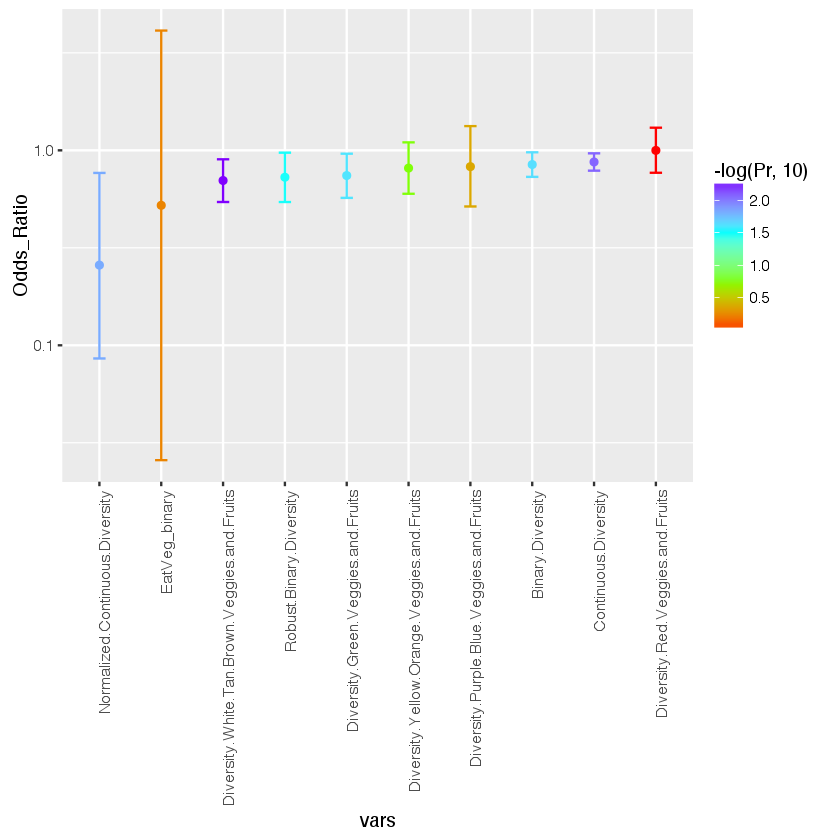


Call:
model(formula = dxCode ~ Diversity.Green.Veggies.and.Fruits + 
    Diversity.White.Tan.Brown.Veggies.and.Fruits, family = family, 
    data = df_tmp)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5035  -1.3654   0.8832   1.0004   1.4600  

Coefficients:
                                             Estimate Std. Error z value
(Intercept)                                    0.7403     0.1309   5.654
Diversity.Green.Veggies.and.Fruits            -0.2290     0.1356  -1.689
Diversity.White.Tan.Brown.Veggies.and.Fruits  -0.3086     0.1315  -2.347
                                             Pr(>|z|)    
(Intercept)                                  1.57e-08 ***
Diversity.Green.Veggies.and.Fruits             0.0912 .  
Diversity.White.Tan.Brown.Veggies.and.Fruits   0.0189 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 639.93  on 478  degrees of freedom
Residual d

Waiting for profiling to be done...


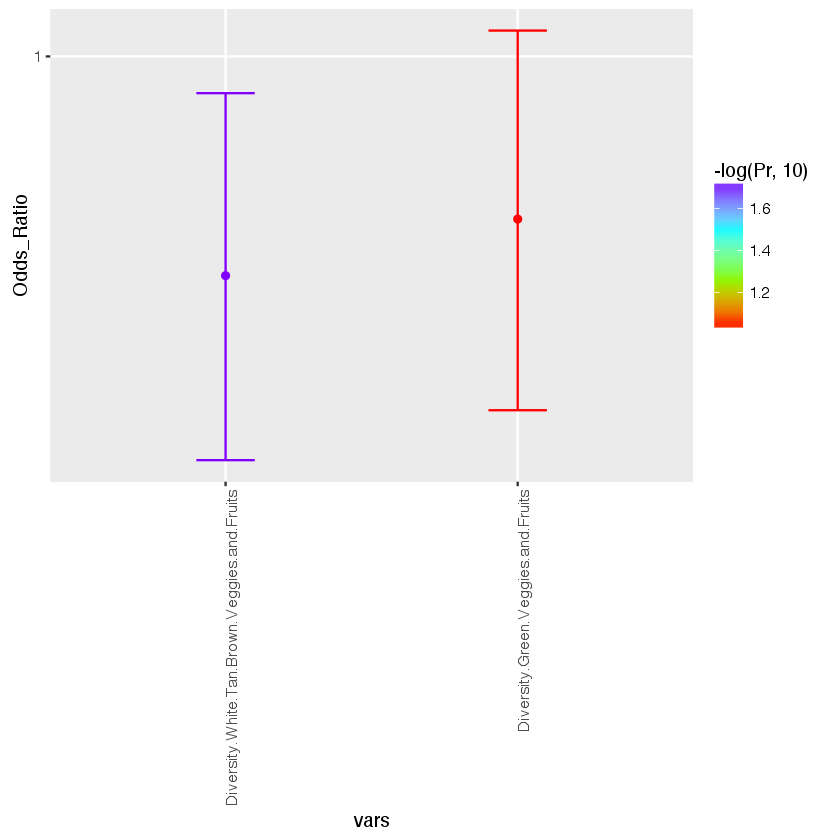

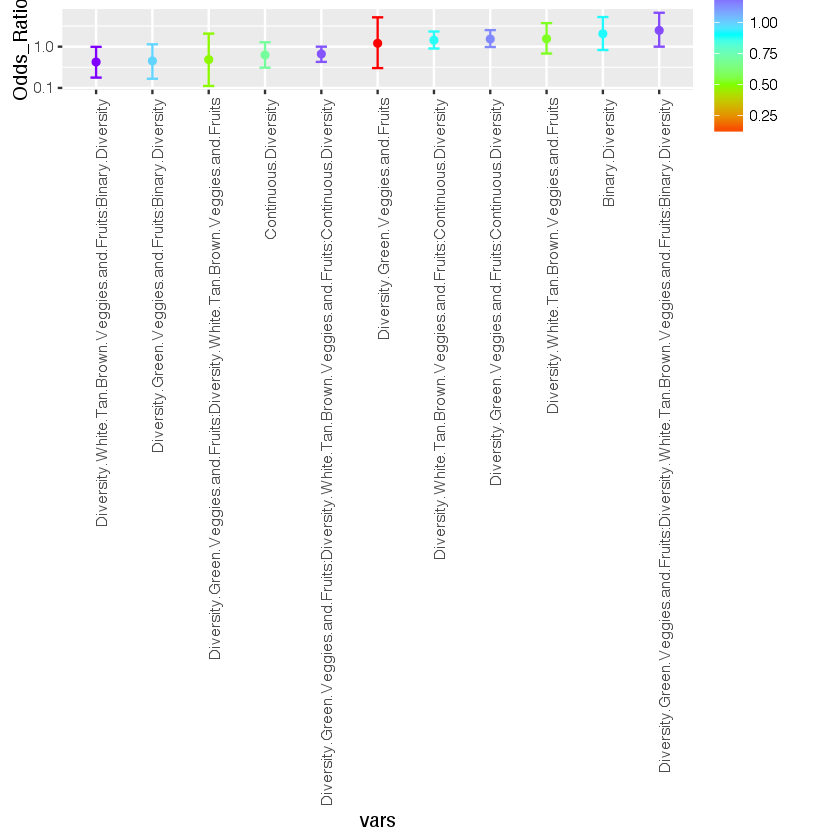

In [411]:
m=vis_logit(mod)
m[[2]]
m[[1]]
summary(mod$final)
m=vis_logit(list(final=step,screen=NULL))
m[[1]]
#summary(step)

Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...


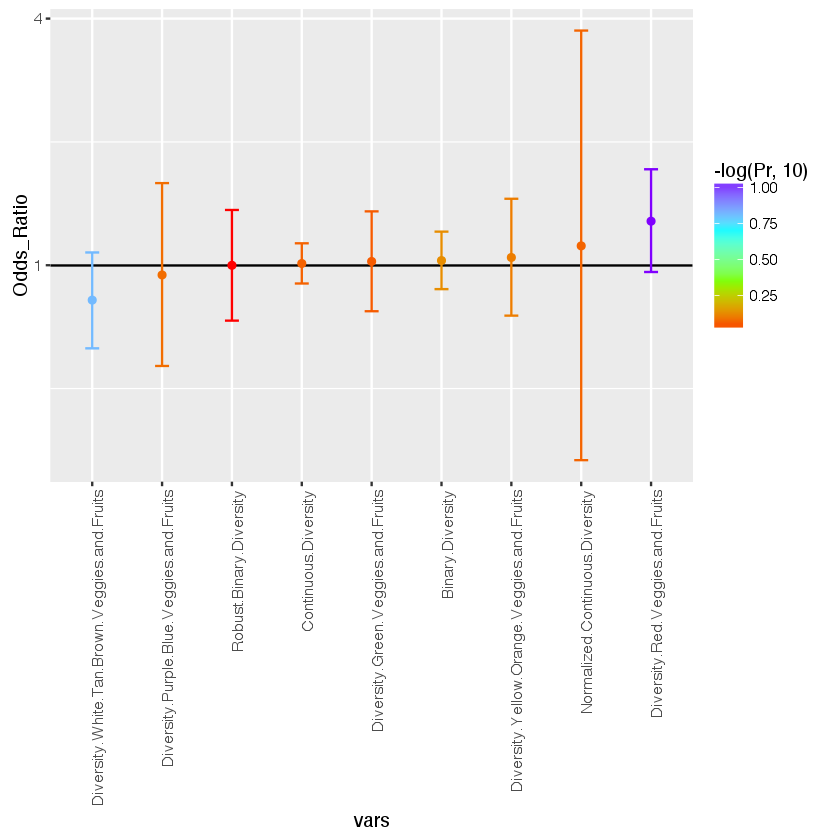

In [153]:
Pr1=c();Pr2=c(); mod1=list(); mod01=list();mod02=list();mod03=list(); mod2=list(); mod3=list(); Pr3=c()
for(i in div_vars){
    mod02[[i]]=glm(dxCode ~ Q14_eats_Vegetables , data=FrVg_color_tmp , family=binomial)
    mod2[[i]]=glm(as.formula(paste('dxCode ~',i,'+ Q14_eats_Vegetables')) , data=FrVg_color_tmp , family=binomial)
    Pr2[i]=anova(mod2[[i]],mod02[[i]],test='LRT')[2,8]
}
attr(mod2,'Pr') = Pr2
vis_out = vis_logit(out=list(screen=mod2,final=NULL))
vis_out$univar

In [139]:
DONT RUN
Pr1=c();Pr2=c(); mod1=list(); mod01=list();mod02=list();mod03=list(); mod2=list(); mod3=list(); Pr3=c()
for(i in div_vars){
    #tmp_dat[[i]] = na.omit( Feed[,c('dxCode',i,'CSBS_Total_1_perMo_factor')] )
    mod01[[i]]=glmer(dxCode ~ (1|CSBS_Total_1_perMo_factor) , data=FrVg_color_tmp , family=binomial)
    mod02[[i]]=glmer(dxCode ~ (1|EatVeg_binary) , data=FrVg_color_tmp , family=binomial)
    mod03[[i]]=glmer(dxCode ~ (1|CSBS_Total_1_perMo_factor) +Q14_eats_Vegetables , data=FrVg_color_tmp , family=binomial)
    mod1[[i]]=glmer(as.formula(paste('dxCode ~',i,'+ (1|CSBS_Total_1_perMo_factor)')) , data=FrVg_color_tmp , family=binomial)
    mod2[[i]]=glmer(as.formula(paste('dxCode ~',i,'+ (1|EatVeg_binary)')) , data=FrVg_color_tmp , family=binomial)
    mod3[[i]]=glmer(as.formula(paste('dxCode ~',i,'+ (1|CSBS_Total_1_perMo_factor) +Q14_eats_Vegetables')) , data=FrVg_color_tmp , family=binomial)
    Pr1[i]=anova(mod1[[i]],mod01[[i]],test='LRT')[2,8]
    Pr2[i]=anova(mod2[[i]],mod02[[i]],test='LRT')[2,8]
    Pr3[i]=anova(mod3[[i]],mod03[[i]],test='LRT')[2,8]
}
attr(mod1,'Pr') = Pr1
attr(mod2,'Pr') = Pr2
attr(mod3,'Pr') = Pr3
#vis_lme(mod1)
#vis_lme(mod2)
#vis_lme(mod3)
vis_out = vis_logit(out=list(screen=mod1,final=NULL))
vis_out$univar

ERROR: Error in parse(text = x, srcfile = src): <text>:1:6: unexpected symbol
1: DONT RUN
         ^
